## Просмотр и подготовка данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [ ]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

Просмотр и предобработку данных сначала сделаем по каждой таблице отдельно.

### calls

**Таблица calls (информация о звонках):**
*	id — уникальный номер звонка
*	call_date — дата звонка
*	duration — длительность звонка в минутах
*	user_id — идентификатор пользователя, сделавшего звонок


In [ ]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В столбце call_date некорректный тип данных (object) - преобразуем его datetime

In [ ]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format="%Y-%m-%d")

In [ ]:
print('Всего абонентов:', data_calls.drop_duplicates(subset='user_id', keep='first')['user_id'].count())

Всего абонентов: 492


Всего в нашей базе 202607 звонка от 492 абонентов. 

Столбец id состоит из user_id и порядкового номера звонка.

Вызывает вопрос часто встречающаяся длительность звонка, равная 0.00. Таких звонков 39613 из 202607.

In [ ]:
print('Звонков продолжительностью 0.00 минут:', data_calls.query('duration == 0.00')['duration'].count())

Звонков продолжительностью 0.00 минут: 39613


Вероятно, так обозначены не состоявшиеся разговоры. Посмотрим, сколько в таблице состоявшихся разговоров.

In [ ]:
print('Звонков продолжительностью больше 0.00 минут:', data_calls.query('duration > 0.00')['duration'].count())

Звонков продолжительностью больше 0.00 минут: 162994


<div class="alert alert-info">Построим гистограмму распределения длительности звонков до округления</div>

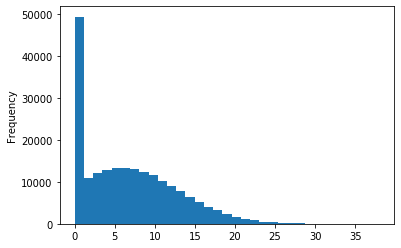

In [ ]:
data_calls['duration'].plot(kind='hist', bins=33)

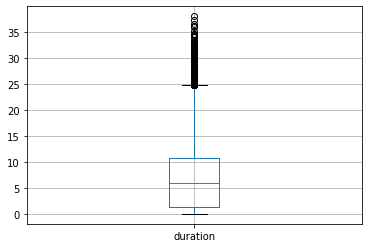

In [ ]:
data_calls.boxplot('duration')

<div class="alert alert-info"> Подавляющее большинство разговаривает до 1 минуты. Остальная часть распределения внешне напоминает нормальное, без отдельных пиков, с вершиной в районе 5-6 минут. На диаграмме размаха видим медиану в 6 минут и границу правого "уса" в 25 минут. Остальное считает выбросами.
</div>

<div class="alert alert-info">Оператор всегда округляет вверх значения минут и мегабайтов, поэтому применим np.ceil к столбцу с длительностью звонков</div>

In [ ]:
data_calls['duration'] = data_calls['duration'].apply(np.ceil)

<div class="alert alert-info">Гистограмма распределения длительности звонков после округления</div>

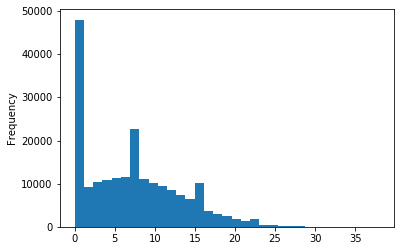

In [ ]:
data_calls['duration'].plot(kind='hist', bins=33)

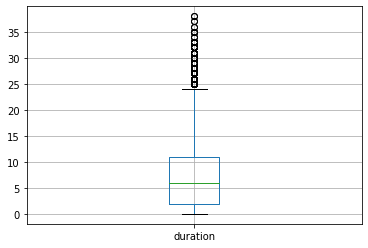

In [ ]:
data_calls.boxplot('duration')

<div class="alert alert-info"> Округление испортило всю красивую гистограмму. После смещений показателей вправо появились яркие пики в 7 и 16 минут. На диаграмме размаха видно уменьшение межквартильного размаха.
</div>

In [ ]:
print('Звонков продолжительностью 0.00 минут:', data_calls.query('duration == 0.00')['duration'].count())

Звонков продолжительностью 0.00 минут: 39613


<div class="alert alert-info">Количество звонков с нулевой длительностью осталось прежним. Казалось бы, было бы справедливо не списывать с абонента деньги за несостоявшийся разговор, однако, операторы считают иначе, и тарифицируют недозвоны как 1 минуту разговора: "Сотовые операторы взимают плату за звонок даже в тех случаях, когда абонент находится вне зоны действия сети. Деньги снимаются со счета за прослушивание автоответчика, а если клиент совершает вызов в другой город, тарификация происходит по междугороднему тарифу." (актуально на 2018 год). 
    
    
А это значит, что все зарегистрированные звонки с длительностью 0.00 мы превращаем в звонки с длительностью в 1 минуту.</div>

In [ ]:
data_calls.loc[data_calls['duration'] == 0.00 ,'duration'] = 1.00

In [ ]:
print('Звонков продолжительностью 0.00 минут:', data_calls.query('duration == 0.00')['duration'].count())

Звонков продолжительностью 0.00 минут: 0


<div class="alert alert-info">Гистограмма распределения длительности звонков после замены нулей</div>

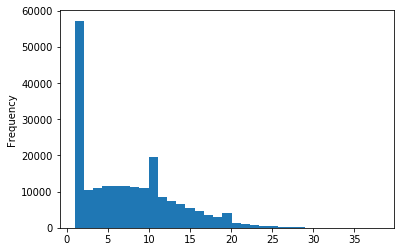

In [ ]:
data_calls['duration'].plot(kind='hist', bins=33)

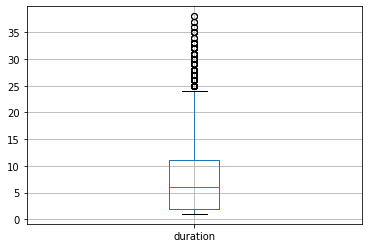

In [ ]:
data_calls.boxplot('duration')

In [ ]:
len(data_calls.query('duration > 20'))

4508

<div class="alert alert-info"> Увеличение количества минимальных разговоров перераспределило данные. Теперь видим пики в 11 и 19 минут. На гистограмме размаха отобразился факт того, что минимальный разговор теперь - минута.
При этом каких-то ярких единичных выбросов, серьезно перекашивающих выборку нет. Всего слишком долгих разговоров 4508. Полагаю, что для начала рассмотреть данные стоит в таком виде. В статистическом обзоре мы постараемся нормировать цены, на которые повлияла чрезмерная длительность.
</div>

Cудя по таблице info, пропущенных значений в этом датафрейме нету. Проверим на дубликаты.

In [ ]:
data_calls.duplicated().sum()

0

Их тоже нет. 

Добавим столбцы с месяцем звонка и приведём к целочисленному типу.

In [ ]:
data_calls['call_month'] = data_calls['call_date'].dt.month

### internet

**Таблица internet (информация об интернет-сессиях):**
*	id — уникальный номер сессии
*	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
*	session_date — дата интернет-сессии
*	user_id — идентификатор пользователя


In [ ]:
data_internet.head(15)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [ ]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Пропущенных значений нет. 

Проделаем уже знакомую операцию по преобразованию данных в тип datetime.

In [ ]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format="%Y-%m-%d")

<div class="alert alert-info">Оператор всегда округляет вверх значения мегабайтов, поэтому применим np.ceil к столбцу с интернет трафиком</div>

In [ ]:
print('Интернет-сессий размером в 0.00 мб:', data_internet.query('mb_used == 0.00')['mb_used'].count())

Интернет-сессий размером в 0.00 мб: 19598


<div class="alert alert-info">Построим гистограмму интернет-трафика до округления</div>

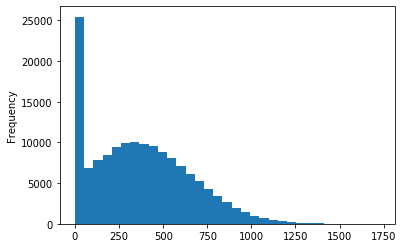

In [ ]:
data_internet['mb_used'].plot(kind='hist', bins=33)

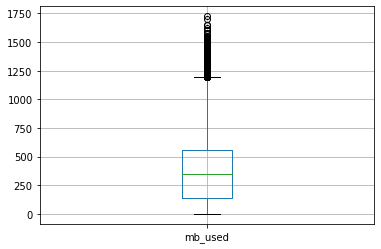

In [ ]:
data_internet.boxplot('mb_used')

 <div class="alert alert-info">Большинство интернет сессий меньше 50мб, дальше снова гладкий график с вершиной в 400-мегабайтную сессию. Диаграмма размаха считает, что картину перекашивают все сессии дольше 1200 мб.
</div>

In [ ]:
data_internet['mb_used'] = data_internet['mb_used'].apply(np.ceil)

In [ ]:
print('Интернет-сессий размером в 0.00 мб:', data_internet.query('mb_used == 0.00')['mb_used'].count())

Интернет-сессий размером в 0.00 мб: 19598


<div class="alert alert-info">Нулевые сессии остались на месте.</div>

<div class="alert alert-info">Построим гистограмму интернет-трафика после округления</div>

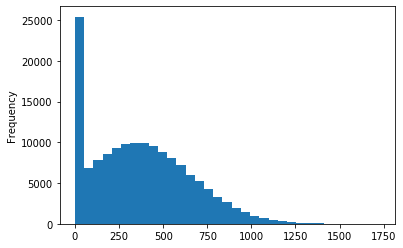

In [ ]:
data_internet['mb_used'].plot(kind='hist', bins=33)

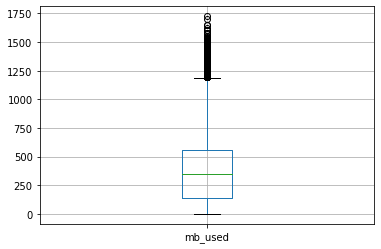

In [ ]:
data_internet.boxplot('mb_used')

<div class="alert alert-info">После округления ожидаемо подросла правая часть гистограммы (теперь вершина сместилась вправо), ведь теперь все интернет сессии чуть длиннее. Но интернет-трафик в целом такой большой, что такое измненение не заметно значительно.
</div>

<div class="alert alert-info">Предположим, что если интернет сессия была зарегистрирована, значит ей приписывается какой-то минимальный трафик, в случае нашего оператора - 1 мб </div>

In [ ]:
data_internet.loc[data_internet['mb_used'] == 0.00 ,'mb_used'] = 1.00

In [ ]:
print('Интернет-сессий размером в 0.00 мб:', data_internet.query('mb_used == 0.00')['mb_used'].count())

Интернет-сессий размером в 0.00 мб: 0


<div class="alert alert-info">Построим гистограмму интернет-трафика после замены нулей</div>

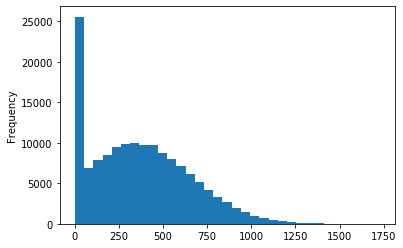

In [ ]:
data_internet['mb_used'].plot(kind='hist', bins=33)

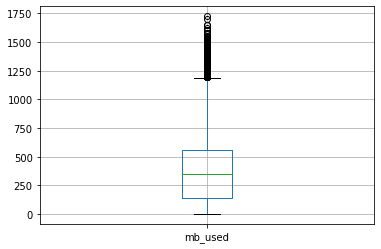

In [ ]:
data_internet.boxplot('mb_used')

In [ ]:
len(data_internet.query('mb_used > 1200'))

494

<div class="alert alert-info">Мы увеличили минимальный интернет-трафик, но в общем море интернета он несколько теряется. На гистограмме вырос небольшой пик в 450 мб.С перекашивающими выборку данными мы пока что поступим так же, как и в длительности разговоров. Ярких отдельных нет. Всего слишком больших сессий 494. В статистическом обзоре мы постараемся нормировать цены, на которые повлияла чрезмерно тяжелые сессии.
</div>

Значения в колонке с мегабайтами заменим гигабайтами (нам в дальнейшем считать гигабайты сверх трафика, потому что цена в таблице тарифов указана за гигабайт).

In [ ]:
data_internet['mb_used'] = data_internet['mb_used']/1024
data_internet.columns = ['id', 'gb_used', 'session_date', 'user_id']

<div class="alert alert-info">Мы не станем округлять гб, так как оператор этого не делает и рассчет ведет за мб, но так как цену указал за гб, мы для нашего удобства привели данные к общему делителю.</div>

In [ ]:
#Есть впечатление, что столбец Unnamed: 0 просто дублирует индексы.
#(data_internet['Unnamed: 0'] - data_internet.index).sum()
#Похоже, так и есть. Удалим data_internet['Unnamed: 0'] за ненадобностью.
#del data_internet['Unnamed: 0']

Добавим столбец с месяцем трафика.

In [ ]:
data_internet['session_month'] = data_internet['session_date'].dt.month

### messages

**Таблица messages (информация о сообщениях):**
*	id — уникальный номер сообщения
*	message_date — дата сообщения
*	user_id — идентификатор пользователя, отправившего сообщение


In [ ]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков нет. Снова преобразуем тип данных в столбце с датой.

In [ ]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format="%Y-%m-%d")

Создадим столбец с месяцем, в который было отправлено сообщение.

In [ ]:
data_messages['message_month'] = data_messages['message_date'].dt.month.astype(int)

### tariffs

**Таблица tariffs (информация о тарифах):**
*	tariff_name — название тарифа
*	rub_monthly_fee — ежемесячная абонентская плата в рублях
*	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
*	messages_included — количество сообщений в месяц, включённых в абонентскую плату
*	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
*	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
*	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
*	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [ ]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [ ]:
data_tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

Выведем вместо mb_per_month_included гигабайты в месяц

In [ ]:
data_tariffs['mb_per_month_included'] = data_tariffs['mb_per_month_included']/1024
data_tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)
#data_tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

### users

**Таблица users (информация о пользователях):**
*	user_id — уникальный идентификатор пользователя
*	first_name — имя пользователя
*	last_name — фамилия пользователя
*	age — возраст пользователя (годы)
*	reg_date — дата подключения тарифа (день, месяц, год)
*	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
*	city — город проживания пользователя
*	tariff — название тарифного плана


In [ ]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Всего в нашем датасете 500 пользователей. 

Пропущенные значения имеются только в churn_date - по условию задания "если значение пропущено, то тариф ещё действовал на момент выгрузки данных". 

Приведем данные в столбце reg_date к типу datetime.

<div class="alert alert-info">Приведем данные в столбцах reg_date и churn_date к типу datetime</div>

In [ ]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format="%Y-%m-%d")
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format="%Y-%m-%d")

Создадим столбцы с месяцем регистрации и отбытия

In [ ]:
data_users['reg_month'] = data_users['reg_date'].dt.month
data_users['churn_month'] = data_users['churn_date'].dt.month

In [ ]:
#Со столбцом churn_date можно было бы поступить так же, но не ясно, что нам даст эта информация. Единственное, что сейчас видно из данного столбца - пользуется абонент тарифом (0) или уже завершил (1). Если мы разделим пользователей по такому критерию, позже сможем сгруппировать по этому признаку и посмотреть на данные, которые объединяют отказавшихся от тарифа пользователей. 

<div class="alert alert-info">Пропуски в churn_date и churn_month трогать не будем - отсутствие информации о разрыве контракта оставим именно отсутвием.</div>

<div class="alert alert-info">Создадим столбец churn_cat со значениями 1 (выбыл) и 0 (действующий абонент)</div>

In [ ]:
data_users['churn_cat'] = data_users['churn_date']
data_users['churn_cat'] = data_users['churn_cat'].fillna('0')
data_users.loc[data_users['churn_cat'] != '0', 'churn_cat'] = '1'
data_users['churn_cat'] = data_users['churn_cat'].astype(int)
data_users['churn_cat'].dtype

dtype('int64')

Посмотрим, на список городов и как распределены пользователи в нашем датафрейме по этим городам. 

In [ ]:
data_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [ ]:
data_users['city'].value_counts().head(15)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Набережные Челны    11
Краснодар           11
Екатеринбург        11
Ульяновск           11
Самара               9
Челябинск            9
Волгоград            8
Пермь                8
Нижний Новгород      8
Name: city, dtype: int64

Создадим столбец, в котором укажем категории городов 'Москва' и 'не Москва'.

In [ ]:
def capital_category(row):
    if row == 'Москва':
        return 1
    else:
        return 0
        
data_users['capital_cat'] = data_users['city'].apply(capital_category)        
data_users['capital_cat'].value_counts()

0    401
1     99
Name: capital_cat, dtype: int64

Проверим, нет ли повторяющихся записей.

In [ ]:
data_users.duplicated().sum()

0

Мы привели пять таблиц к подходящему для последующей работы виду: разобрались с пропусками, типами данных, проверили на дубликаты, удалили лишнюю переменную. 

## Создание единого датафрейма

### pivot_table по звонкам, сообщениям и интернет трафику

Создадим таблицу с суммарной длительностью звонков в месяц и количеством звонков в месяц.

In [ ]:
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['sum', 'count']).reset_index()
data_calls_pivot.columns = ['user_id', 'month', 'duration_month', 'calls_month']
data_calls_pivot.sample(5)

,user_id,month,duration_month,calls_month
1259,1199,12,912.0,120
286,1045,12,264.0,36
11,1002,7,219.0,26
924,1148,12,861.0,123
3172,1499,11,624.0,74


In [ ]:
#Создадим сводную таблицу для звонков с ненулевой длительностью.
#data_calls_notnull_pivot = data_calls.query('duration>0').pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['sum', 'count']).reset_index()
#data_calls_notnull_pivot.columns = ['user_id', 'month', 'duration_notnull_month', 'calls_notnull_month']
#data_calls_notnull_pivot.sample(5)
#Объединим таблицы - теперь у нас единая сводная таблица по звонкам (всем и с ненулевой длительностью).
#data_calls_pivot = data_calls_pivot.merge(data_calls_notnull_pivot, on=['user_id', 'month'], how='left')
#data_calls_pivot.sample(5)

<div class="alert alert-info">Звонков с нулевой длительностью в таблице больше нет</div>

Создадим столбцы с суммой потраченных мб в месяц каждым пользователем.

In [ ]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'session_month'], values='gb_used', aggfunc='sum').reset_index()
data_internet_pivot.columns = ['user_id', 'month', 'gb_used_month']
data_internet_pivot.sample(5)

,user_id,month,gb_used_month
2462,1386,10,24.346680
1655,1262,10,18.721680
2940,1459,11,15.137695
570,1091,5,10.464844
660,1104,6,12.726562


Создадим таблицу с суммой отправленных каждым пользователем в месяц сообщений.

In [ ]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc='count').reset_index()
data_messages_pivot.columns = ['user_id', 'month', 'messages_per_month']
data_messages_pivot.sample(5)

,user_id,month,messages_per_month
886,1168,11,42
1652,1318,9,56
1106,1211,12,10
1021,1191,9,106
1483,1285,3,110


### Присоединение таблиц. Работа с пропусками в новом датафрейме. 

Соединим таблицы в одну по user_id и month

In [ ]:
print('Количество звонков:', len(data_calls_pivot)) 
print('Количество сообщений:', len(data_messages_pivot))
print('Количество интернет-сессий:', len(data_internet_pivot))
print('Количество user_id:', len(data_users))

Количество звонков: 3174
Количество сообщений: 2717
Количество интернет-сессий: 3203
Количество user_id: 500


In [ ]:
data = data_calls_pivot.merge(data_messages_pivot, on=['user_id', 'month'], how='outer')
data = data.merge(data_internet_pivot, on=['user_id', 'month'], how='outer')
data = data.merge(data_users, on='user_id', how='outer')

In [ ]:
print('Количество строк со звонками в месяц в data:', data['calls_month'].count())
print('Количество строк с сообщениями в месяц в data:', data['messages_per_month'].count())
print('Количество строк с потраченными в месяц гб в data:', data['gb_used_month'].count())
print('Количество уникальных user_id в data:', len(data['user_id'].unique()))

Количество строк со звонками в месяц в data: 3174
Количество строк с сообщениями в месяц в data: 2717
Количество строк с потраченными в месяц гб в data: 3203
Количество уникальных user_id в data: 500


<div class="alert alert-info">Все данные на месте</div>

In [ ]:
data.isna().sum()

user_id                  0
month                    2
duration_month          42
calls_month             42
messages_per_month     499
gb_used_month           13
age                      0
churn_date            3027
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
reg_month                0
churn_month           3027
churn_cat                0
capital_cat              0
dtype: int64

Появились два пропущенных месяца для каких-то пользователей - предполагаем, что они вообще не пользовались связью какой-то месяц. Появились, видимо, после прикручивания таблицы data_users, которую мы присоединяли только по user_id, и для двух имеющихся в ней user_id не нашлось данных в предыдущей таблице. Посмотрим на них.

In [ ]:
data['month'] = data['month'].fillna('who_are_you')

In [ ]:
data.query('month == "who_are_you"')

,user_id,month,duration_month,calls_month,messages_per_month,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month,churn_cat,capital_cat
3214,1128,who_are_you,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,12.0,1,0
3215,1371,who_are_you,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,12.0,1,0


<div class="alert alert-info">Так и есть - NAN по всем пунктам. И посмотрев на reg_month и churn_month, можем отметить, что оба абонента были абонентами меньше 1 месяца. И хоть мы и можем восстановить месяц (декабрь у обоих), удалим эти строки - в них не содержится полезной информации.</div>

In [ ]:
data = data.query('month != "who_are_you"').reset_index()

In [ ]:
data['month'] = data['month'].astype(int)

Вернули столбцу month полагающийся тип данных

Также мы видим пропуски в duration_month, messages_per_month, gb_used_month, появившиеся в результате слияния таблиц - это люди, которые не отправляли смс, не делали звонков и не пользовались интернетом в какие-то месяцы (этих значений не было в изначальных таблицах), поэтому можно заменить на 0 - 0 сообщений, 0 гб и 0 минут и соответственно 0 звонов в месяц. 

In [ ]:
data['duration_month'] = data['duration_month'].fillna(0)
data['messages_per_month'] = data['messages_per_month'].fillna(0)
data['gb_used_month'] = data['gb_used_month'].fillna(0)
data['calls_month'] = data['calls_month'].fillna(0)

In [ ]:
data.isna().sum()

index                    0
user_id                  0
month                    0
duration_month           0
calls_month              0
messages_per_month       0
gb_used_month            0
age                      0
churn_date            3027
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
reg_month                0
churn_month           3027
churn_cat                0
capital_cat              0
dtype: int64

<div class="alert alert-info">Пропуски в churn_date и churn_month мы решили пока не заполнять. churn_date имеет тип datetime, поэтому замена на 0 бессмысленна.  churn_date и churn_month мы будем анализировать внутри категории выбывших, сравнивать с остальными нам незачем. </div>

<div class="alert alert-info">Столбцов с ненулевыми звонками и их длительностью больше нет из-за предыдущих правок.</div>

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 18 columns):
index                 3214 non-null int64
user_id               3214 non-null int64
month                 3214 non-null int64
duration_month        3214 non-null float64
calls_month           3214 non-null float64
messages_per_month    3214 non-null float64
gb_used_month         3214 non-null float64
age                   3214 non-null int64
churn_date            187 non-null datetime64[ns]
city                  3214 non-null object
first_name            3214 non-null object
last_name             3214 non-null object
reg_date              3214 non-null datetime64[ns]
tariff                3214 non-null object
reg_month             3214 non-null int64
churn_month           187 non-null float64
churn_cat             3214 non-null int64
capital_cat           3214 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(7), object(4)
memory usage: 452.1+ KB


Уберем лишние столбцы с именем и фамилией, нам достаточно id. index дублирует индекс таблицы.

In [ ]:
del data['first_name']
del data['last_name']
del data['index']

In [ ]:
data_tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [ ]:
data = data.merge(data_tariffs, on='tariff', how='left')
data.head()

,user_id,month,duration_month,calls_month,messages_per_month,gb_used_month,age,churn_date,city,reg_date,...,churn_month,churn_cat,capital_cat,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,164.0,22.0,22.0,2.204102,52,NaT,Краснодар,2018-05-25,...,NaN,0,0,1000,30.0,3000,1950,150,1,1
1,1000,6,187.0,43.0,60.0,22.716797,52,NaT,Краснодар,2018-05-25,...,NaN,0,0,1000,30.0,3000,1950,150,1,1
2,1000,7,346.0,47.0,75.0,13.688477,52,NaT,Краснодар,2018-05-25,...,NaN,0,0,1000,30.0,3000,1950,150,1,1
3,1000,8,418.0,52.0,81.0,13.742188,52,NaT,Краснодар,2018-05-25,...,NaN,0,0,1000,30.0,3000,1950,150,1,1
4,1000,9,478.0,58.0,57.0,14.241211,52,NaT,Краснодар,2018-05-25,...,NaN,0,0,1000,30.0,3000,1950,150,1,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
duration_month           3214 non-null float64
calls_month              3214 non-null float64
messages_per_month       3214 non-null float64
gb_used_month            3214 non-null float64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
reg_month                3214 non-null int64
churn_month              187 non-null float64
churn_cat                3214 non-null int64
capital_cat              3214 non-null int64
messages_included        3214 non-null int64
gb_per_month_included    3214 non-null float64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_

In [ ]:
data.duplicated().sum()

0

Пропусков и дубликатов нет.

### Создание новых столбцов - траты сверх тарифа

Создадим столбцы, в которых укажем переплаты сверх тарифа за минуты, сообщения и гб.
Для этого отнимем от реально потраченных минут, сообщений и гб их количество в пакете и умножим на стоимость за минуту/сообщение/гб сверх тарифа. Отрицательные значения (то есть те, где выхода за тарифный пакет не было) заменим на 0, так как переплаты там нет. 

Переплата за минуты

In [ ]:
data['overpaid_minutes'] = (data['duration_month'] - data['minutes_included'])*data['rub_per_minute']
data.loc[data['overpaid_minutes']<0, 'overpaid_minutes'] = 0
len(data[data['overpaid_minutes']>0])

811

Переплата за сообщения

In [ ]:
data['overpaid_messages'] = (data['messages_per_month'] - data['messages_included'])*data['rub_per_message']
data.loc[data['overpaid_messages']<0, 'overpaid_messages'] = 0
len(data[data['overpaid_messages']>0])

564

Переплата за интернет 

In [ ]:
data['overpaid_gb'] = (data['gb_used_month'] - data['gb_per_month_included'])*data['rub_per_gb']
data.loc[data['overpaid_gb']<0, 'overpaid_gb'] = 0
len(data[data['overpaid_gb']>0])

1444

Итоговая месячная плата: переплаты + плата за тариф

In [ ]:
data['overpaid'] = data['overpaid_minutes'] + data['overpaid_messages'] + data['overpaid_gb']

In [ ]:
data['total_paid'] = data['overpaid'] + data['rub_monthly_fee']

In [ ]:
data.head()

,user_id,month,duration_month,calls_month,messages_per_month,gb_used_month,age,churn_date,city,reg_date,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,overpaid_minutes,overpaid_messages,overpaid_gb,overpaid,total_paid
0,1000,5,164.0,22.0,22.0,2.204102,52,NaT,Краснодар,2018-05-25,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6,187.0,43.0,60.0,22.716797,52,NaT,Краснодар,2018-05-25,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7,346.0,47.0,75.0,13.688477,52,NaT,Краснодар,2018-05-25,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8,418.0,52.0,81.0,13.742188,52,NaT,Краснодар,2018-05-25,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9,478.0,58.0,57.0,14.241211,52,NaT,Краснодар,2018-05-25,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


### Создание таблицы размера сессий
<div class="alert alert-info">

<div class="alert alert-info">
Присоединим к таблицам с длительностью звонков и размером интернет-сессий данные о тарифах.
</div>

In [ ]:
data_call_duration = data_calls[['user_id', 'duration']].join(data_users[['user_id', 'tariff']].set_index('user_id'), on='user_id')
data_call_duration.sample(5)

,user_id,duration,tariff
93290,1233,1.0,smart
141855,1360,11.0,ultra
17740,1049,2.0,ultra
117040,1300,19.0,ultra
78725,1196,2.0,ultra


In [ ]:
print('Количество звонков в таблице data_calls:', data_calls['duration'].count(), ', количество звонков в таблице data_call_duration:', data_call_duration['duration'].count())

Количество звонков в таблице data_calls: 202607 , количество звонков в таблице data_call_duration: 202607


In [ ]:
data_internet_session = data_internet[['user_id', 'gb_used']].join(data_users[['user_id', 'tariff']].set_index('user_id'), on='user_id')
data_internet_session.sample(5)

,user_id,gb_used,tariff
60428,1204,0.286133,smart
47485,1164,0.250000,smart
4964,1014,0.277344,smart
42975,1148,0.402344,ultra
57942,1195,0.000977,smart


In [ ]:
print('Количество интернет-сессий в таблице data_internet:', data_internet['gb_used'].count(), ', количество интернет-сессий в таблице data_internet_session:', data_internet_session['gb_used'].count())

Количество интернет-сессий в таблице data_internet: 149396 , количество интернет-сессий в таблице data_internet_session: 149396


<div class="alert alert-info">
Получили две таблицы, внутри которым можем сравнить данные по тарифам.
</div>

## Исследовательский анализ данных

### Сравнение тарифов

<div class="alert alert-info">
Построим гистограммы длительности звонков и размеров интернет-сессий.
</div>

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

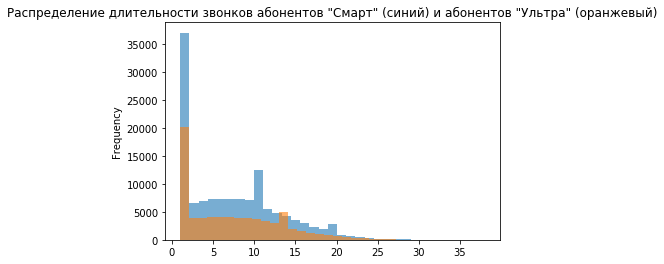

In [ ]:
data_call_duration.groupby('tariff')['duration'].plot(kind='hist', alpha=0.6, bins=33, title='Распределение длительности звонков абонентов "Смарт" (синий) и абонентов "Ультра" (оранжевый)')

In [ ]:
data_call_duration.pivot_table(index='tariff', values='duration', aggfunc='var')

,duration
tariff,
smart,32.851216
ultra,32.903775


<div class="alert alert-info">
У "Смарта" значительно больше минимальных звонков (минута). Распределения длительности похожи, гистограмма "Ультра" более сглаженная - бОльшее количество абонентов позволяют себе поговорить подольше.

При этом дисперсии почти одинаковы.
</div>

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: gb_used, dtype: object

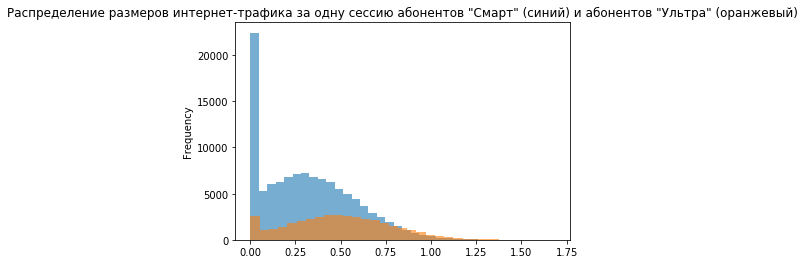

In [ ]:
data_internet_session.groupby('tariff')['gb_used'].plot(kind='hist', alpha=0.6, bins=33, title='Распределение размеров интернет-трафика за одну сессию абонентов "Смарт" (синий) и абонентов "Ультра" (оранжевый)')

In [ ]:
data_internet_session.pivot_table(index='tariff', values='gb_used', aggfunc='var')

,gb_used
tariff,
smart,0.064144
ultra,0.078577


<div class="alert alert-info">
Абоненты "Смарт" гораздо чаще тратят минимальное количество гб, если не считать минимальных сессий, большинство тратит около трети гигабайта за сессию. Распределение "Ультра" более сглаженное, большинство тратит около половина гб за сессию, и большее, чем в "Смарт" количество сессий, выходит за 0.8 гб.

Дисперсии несущественно отличаются в пользу "Ультра", абоненты которой могут потратить максимальное кол-во гб за сессию.
</div>

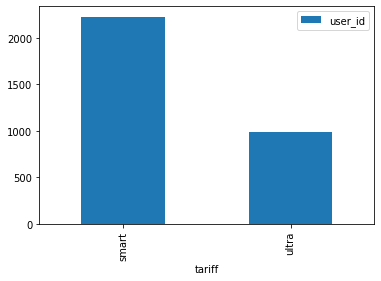

In [ ]:
data.pivot_table(index='tariff', values='user_id', aggfunc='count').plot(kind='bar')

Пользователей тарифа "Смарт" больше, чем тарифа "Ультра"

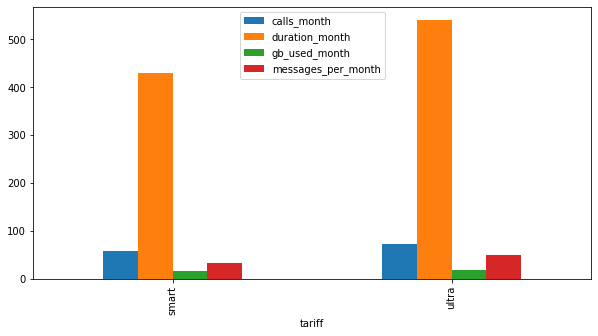

In [ ]:
data.pivot_table(index='tariff', values=['duration_month', 'calls_month', 'messages_per_month',
       'gb_used_month']).plot(kind='bar', figsize=(10,5))

При этом абоненты "Ультра" более активно пользуются услугами оператора, тогда как абоненты "Смарт" экономнее относятся к звонкам и сообщениям.

<div class="alert alert-info">Посмотрим, как распределены ежемесячные платежи, длительности и количества звонков, количества сообщений и гигабайт, а также возраст абонентов у двух тарифов относительно друг друга.</div>

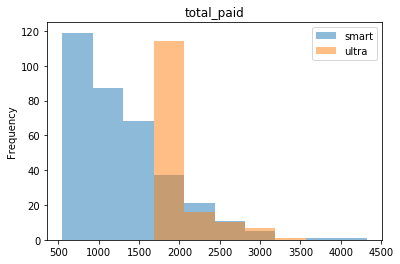

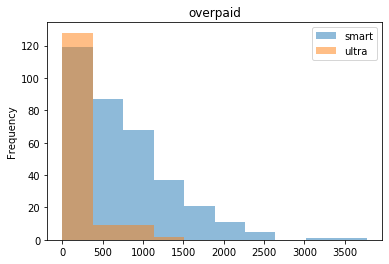

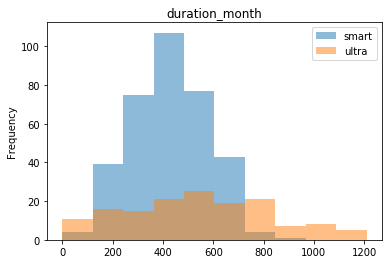

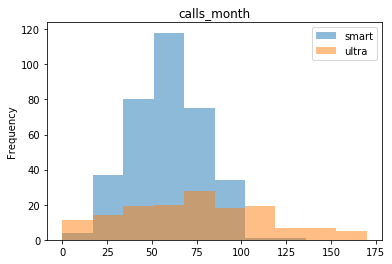

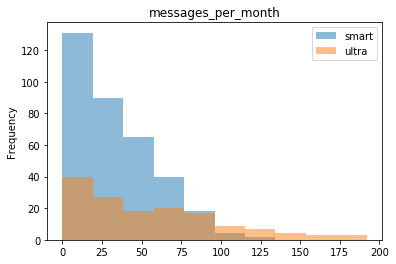

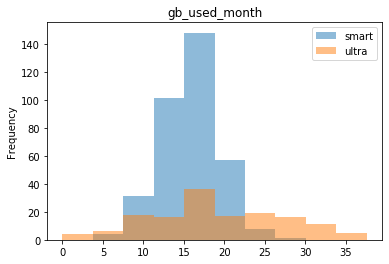

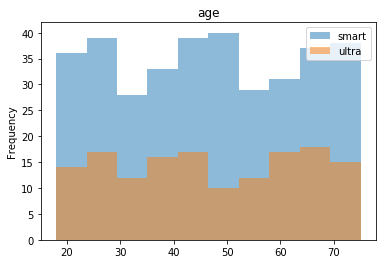

In [ ]:
data.query('tariff == "smart"').pivot_table(index='user_id', values='total_paid').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='total_paid'), on='user_id', how='outer').rename(columns={'total_paid_x':'smart', 'total_paid_y':'ultra'}).plot(kind='hist', alpha=0.5, title='total_paid')
data.query('tariff == "smart"').pivot_table(index='user_id', values='overpaid').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='overpaid'), on='user_id', how='outer').rename(columns={'overpaid_x':'smart', 'overpaid_y':'ultra'}).plot(kind='hist', alpha=0.5, title='overpaid')
data.query('tariff == "smart"').pivot_table(index='user_id', values='duration_month').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='duration_month'), on='user_id', how='outer').rename(columns={'duration_month_x':'smart', 'duration_month_y':'ultra'}).plot(kind='hist', alpha=0.5, title='duration_month')
data.query('tariff == "smart"').pivot_table(index='user_id', values='calls_month').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='calls_month'), on='user_id', how='outer').rename(columns={'calls_month_x':'smart', 'calls_month_y':'ultra'}).plot(kind='hist', alpha=0.5, title='calls_month')
data.query('tariff == "smart"').pivot_table(index='user_id', values='messages_per_month').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='messages_per_month'), on='user_id', how='outer').rename(columns={'messages_per_month_x':'smart', 'messages_per_month_y':'ultra'}).plot(kind='hist', alpha=0.5, title='messages_per_month')
data.query('tariff == "smart"').pivot_table(index='user_id', values='gb_used_month').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='gb_used_month'), on='user_id', how='outer').rename(columns={'gb_used_month_x':'smart', 'gb_used_month_y':'ultra'}).plot(kind='hist', alpha=0.5, title='gb_used_month')
data.query('tariff == "smart"').pivot_table(index='user_id', values='age').merge(data.query('tariff == "ultra"').pivot_table(index='user_id', values='age'), on='user_id', how='outer').rename(columns={'age_x':'smart', 'age_y':'ultra'}).plot(kind='hist', alpha=0.5, title='age')
plt.show()


<div class="alert alert-info">
<b>total_paid:</b> Видим, что абоненты "Смарт" часто платят сверх фиксированной платы за тариф, поэтому данные распределены разнообразно, тогда как абоненты "Ультра" в подавляющем большинстве платят только фикс, редко переплачивая.
    
<b>overpaid:</b> Здесь, собственно, видно распределения переплат - у абонентов "Ультра" минимальны, у "Смарта" - разнообразны. 
    
<b>duration_month:</b> Видим, что абоненты "Смарта" в большинстве своём говорят ограниченное время (большинство - 400-500мин в месяц), тогда как абоненты "Ультра" не ограничивают себя в длительности разговоров, а некоторые и вовсе почти не пользуются телефонной связью.
    
<b>calls_month:</b>На гистограммах количества звонков видим, что абоненты "Смарт" пользуются звонками, но ограничивают себя. Абоненты "Ультра" не ограничивают число звонков, или вовсе почти не звонят по телефону (перешли на интернет-звонки, например).
    
<b>messages_per_month:</b> То же касается и сообщений. Ими абоненты обоих тарифов в основном пользуются минимально, при этом некоторые абоненты "Ультра" отправляют их в большом количестве.
    
<b>gb_used_month:</b> Интернет-трафик на двух тарифах примерно одинаковый, но абоненты "Ультра" позволяют себе большее количество гб.
    
<b>age:</b> По возрасту выборки особо не отличаются.
</div>



<div class="alert alert-info">Сравним дисперсии изучаемых переменных</div>

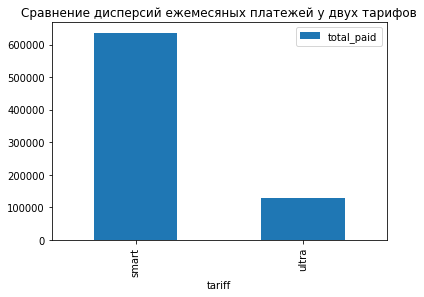

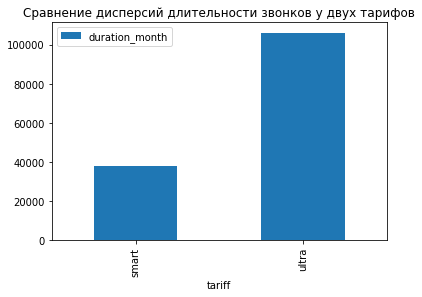

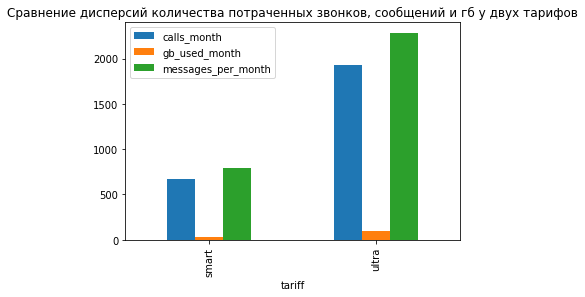

In [ ]:
data.pivot_table(index='tariff', values='total_paid', aggfunc='var').plot(kind='bar', title='Сравнение дисперсий ежемесяных платежей у двух тарифов')
data.pivot_table(index='tariff', values='duration_month', aggfunc='var').plot(kind='bar', title='Сравнение дисперсий длительности звонков у двух тарифов')
data.pivot_table(index='tariff', values=['calls_month', 'messages_per_month', 'gb_used_month'], aggfunc='var').plot(kind='bar', title='Сравнение дисперсий количества потраченных звонков, сообщений и гб у двух тарифов')

<div class="alert alert-info">
    
<b>Сравнение дисперсий ежемесяных платежей у двух тарифов:</b> Как мы уже видели ранее, у "Смарт" куда выше разнообразие ежемесячных платежей.
    
<b>Сравнение дисперсий длительности звонков у двух тарифов:</b> Абоненты "Ультра" позволяют себе почти любую месячную длительность разговоров. "Смарт" имеет куда меньшее разнообразие.
    
<b>Сравнение дисперсий количества потраченных звонков, сообщений и гб у двух тарифов:</b> Разброс ежемесячного количества сообщений, звонков и гб существенно выше у "Ультра".

</div>

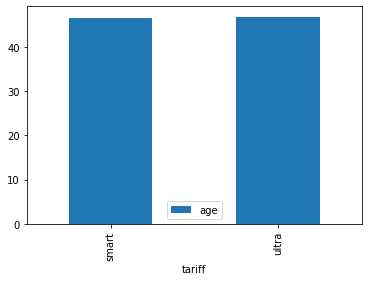

In [ ]:
data.pivot_table(index='tariff', values='age').plot(kind='bar')

Средний возраст у абонентов двух тарифов одинаковый.

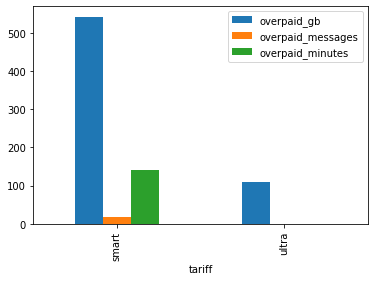

In [ ]:
data.pivot_table(index='tariff', values=['overpaid_minutes', 'overpaid_messages',
       'overpaid_gb']).plot(kind='bar')

Абоненты "Смарт" гораздо чаще покупают услуги сверх тарифа. "Ультра" - докупают гигабайты. 

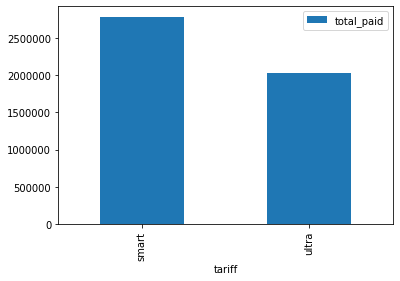

In [ ]:
data.pivot_table(index='tariff', values='total_paid', aggfunc='sum').plot(kind='bar')

В целом по выборке сумма дохода от "Смарта" выше, чем от "Ультра".

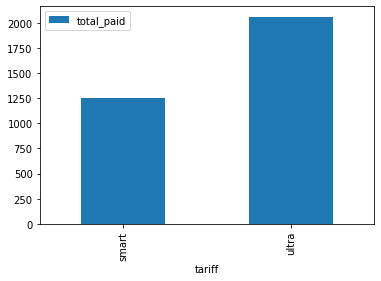

In [ ]:
data.pivot_table(index='tariff', values='total_paid').plot(kind='bar')

Но в среднем "Ультра" приносит бОльший доход оператору, чем "Смарт".

In [ ]:
data.groupby('tariff')['total_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1251.409667,797.708109,550.0,553.0,987.664062,1703.507812,6768.335938
ultra,985.0,2060.591390,356.428319,1950.0,1950.0,1950.000000,1950.000000,4743.896484


Мы видим, что доход от абонентов "Ультра" в нашем датасете выше, чем от абонентов "Смарт". Но "Ультра" и дороже. При этом дисперсия у "Смарта" гораздо шире. 

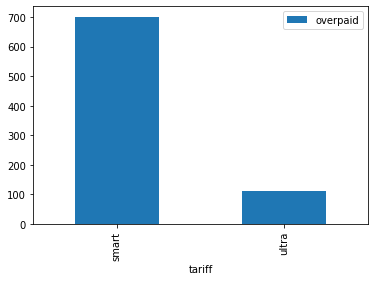

In [ ]:
data.pivot_table(index='tariff', values='overpaid').plot(kind='bar')

In [ ]:
data.groupby('tariff')['overpaid'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,701.409667,797.708109,0.0,3.0,437.664062,1153.507812,6218.335938
ultra,985.0,110.591390,356.428319,0.0,0.0,0.000000,0.000000,2793.896484


Все из-за оплаты услуг сверх тарифа - абоненты "Смарт" гораздо чаще вылезают за пределы пакета.  

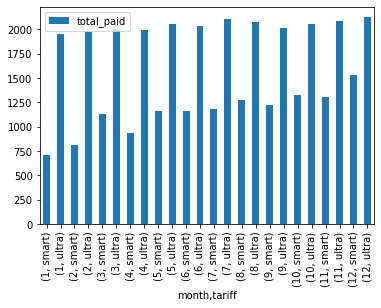

In [ ]:
data.pivot_table(index=['month', 'tariff'], values='total_paid').plot(kind='bar')

При этом динамика платежей в течение года ярче у абонентов "Смарт" - похоже, они готовы оплачивать только необходимые им услуги, не покупая больших пакетов. В то время как абоненты "Ультра" готовы стабильно платить одну и ту же цену в течение года. Несмотря на переплаты, абоненты "Смарт" всё равно в среднем платят меньше. 

### Сравнение абонентов из Москвы и регионов

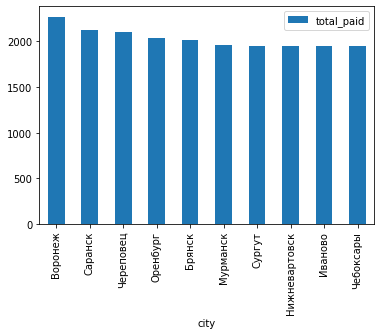

In [ ]:
data.pivot_table(index='city', values='total_paid').sort_values(by=('total_paid'), ascending=False).head(10).plot(kind='bar')

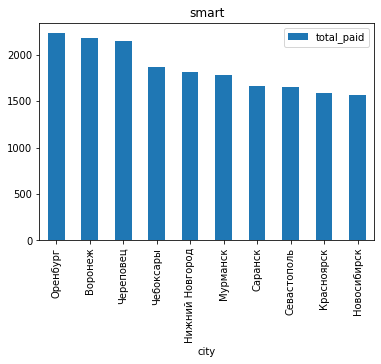

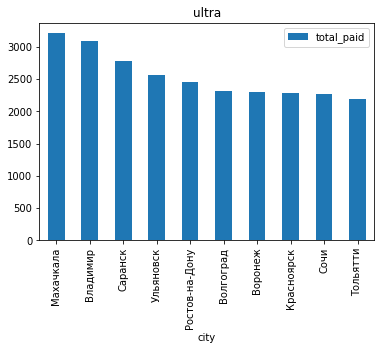

In [ ]:
data.query('tariff == "smart"').pivot_table(index='city', values='total_paid').sort_values(by=('total_paid'), ascending=False).head(10).plot(kind='bar', title='smart')
data.query('tariff == "ultra"').pivot_table(index='city', values='total_paid').sort_values(by=('total_paid'), ascending=False).head(10).plot(kind='bar', title='ultra')
plt.show()

Топ10 городов по размеру среднего платежа у двух тарифов несколько различаются. И Москвы в лидерах нет. 

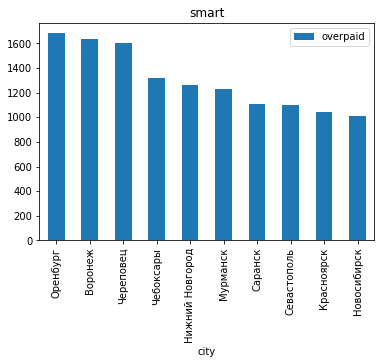

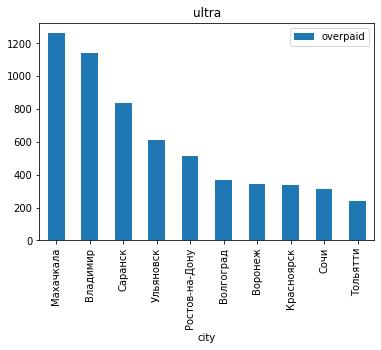

In [ ]:
data.query('tariff == "smart"').pivot_table(index='city', values='overpaid').sort_values(by=('overpaid'), ascending=False).head(10).plot(kind='bar', title='smart')
data.query('tariff == "ultra"').pivot_table(index='city', values='overpaid').sort_values(by=('overpaid'), ascending=False).head(10).plot(kind='bar', title='ultra')
plt.show()

Потому что в этих топ10 городах выше средний размер переплаты.

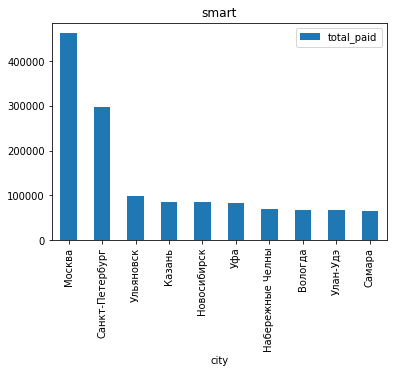

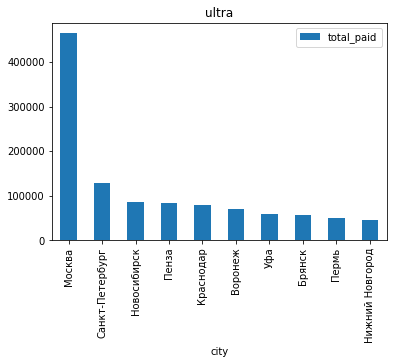

In [ ]:
data.query('tariff == "smart"').pivot_table(index='city', values='total_paid', aggfunc='sum').sort_values(by=('total_paid'), ascending=False).head(10).plot(kind='bar', title='smart')
data.query('tariff == "ultra"').pivot_table(index='city', values='total_paid', aggfunc='sum').sort_values(by=('total_paid'), ascending=False).head(10).plot(kind='bar', title='ultra')
plt.show()

Однако, в целом от Москвы самый большой доход по обоим тарифам (мы помним, что там больше всего абонентов)

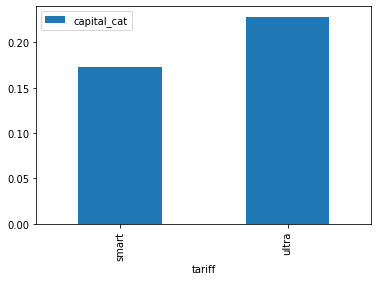

In [ ]:
data.pivot_table(index='tariff', values='capital_cat').plot(kind='bar')


Доля москвичей среди абонентов "Ультра" выше, чем среди абонентов "Смарт"

In [ ]:
data_capital = data.query('tariff == "smart"').pivot_table(index='capital_cat', values=['total_paid', 'overpaid']).reset_index()
data_capital_ultra = data.query('tariff == "ultra"').pivot_table(index='capital_cat', values=['total_paid', 'overpaid']).reset_index()
data_capital.columns = ['capital_cat', 'smart_overpaid', 'smart_total_paid']
data_capital_ultra.columns = ['capital_cat', 'ultra_overpaid', 'ultra_total_paid']
data_capital[['ultra_overpaid', 'ultra_total_paid']] = data_capital_ultra[['ultra_overpaid', 'ultra_total_paid']]
data_capital

,capital_cat,smart_overpaid,smart_total_paid,ultra_overpaid,ultra_total_paid
0,0,712.279474,1262.279474,109.671117,2059.671117
1,1,649.510565,1199.510565,113.699870,2063.699870


Средние цифры доходов от двух тарифов и переплат среди москвичей и не москвичей принципиально не различаются. Можно отметить, что немосковские пользователи "Смарт" в среднем больше переплачивают сверх тарифа, когда в "Ультра" наоборот - переплат больше у москвичей.

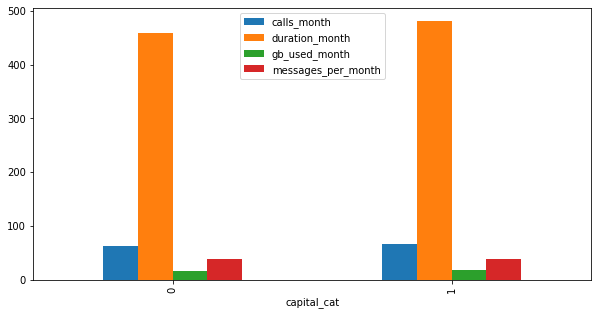

In [ ]:
data.pivot_table(index='capital_cat', values=['duration_month', 'calls_month', 'messages_per_month',
       'gb_used_month']).plot(kind='bar', figsize=(10,5))

И по расходу пакета услуг столичные и нестоличные абоненты принципиально не различаются.

<div class="alert alert-info">Посмотрим, как распределены ежемесячные платежи, длительности и количества звонков, количества сообщений и гигабайт, а также возраст абонентов из Москвы и регионов относительно друг друга.</div>

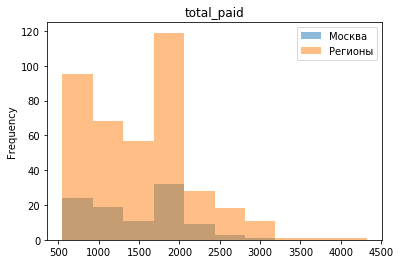

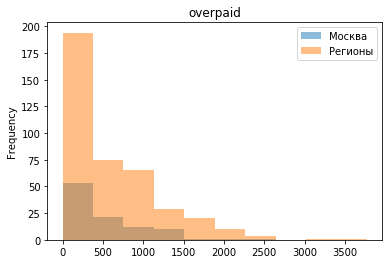

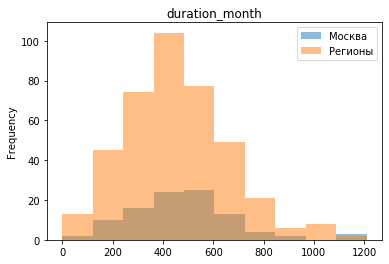

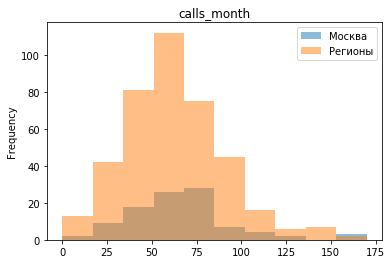

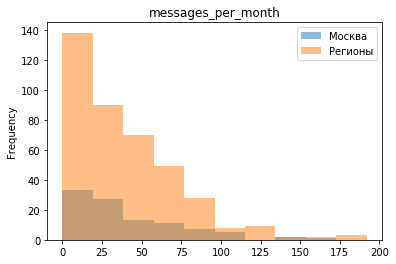

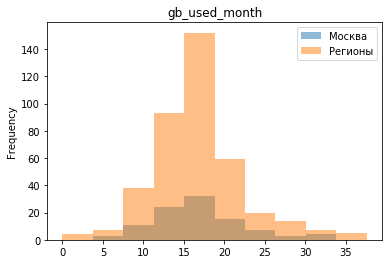

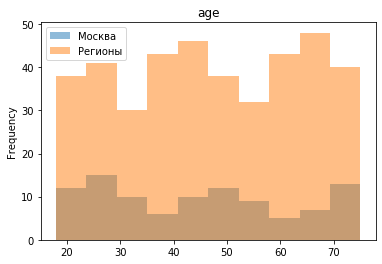

In [ ]:
data.query('capital_cat == 1').pivot_table(index='user_id', values='total_paid').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='total_paid'), on='user_id', how='outer').rename(columns={'total_paid_x':'Москва', 'total_paid_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='total_paid')
data.query('capital_cat == 1').pivot_table(index='user_id', values='overpaid').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='overpaid'), on='user_id', how='outer').rename(columns={'overpaid_x':'Москва', 'overpaid_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='overpaid')
data.query('capital_cat == 1').pivot_table(index='user_id', values='duration_month').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='duration_month'), on='user_id', how='outer').rename(columns={'duration_month_x':'Москва', 'duration_month_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='duration_month')
data.query('capital_cat == 1').pivot_table(index='user_id', values='calls_month').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='calls_month'), on='user_id', how='outer').rename(columns={'calls_month_x':'Москва', 'calls_month_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='calls_month')
data.query('capital_cat == 1').pivot_table(index='user_id', values='messages_per_month').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='messages_per_month'), on='user_id', how='outer').rename(columns={'messages_per_month_x':'Москва', 'messages_per_month_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='messages_per_month')
data.query('capital_cat == 1').pivot_table(index='user_id', values='gb_used_month').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='gb_used_month'), on='user_id', how='outer').rename(columns={'gb_used_month_x':'Москва', 'gb_used_month_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='gb_used_month')
data.query('capital_cat == 1').pivot_table(index='user_id', values='age').merge(data.query('capital_cat == 0').pivot_table(index='user_id', values='age'), on='user_id', how='outer').rename(columns={'age_x':'Москва', 'age_y':'Регионы'}).plot(kind='hist', alpha=0.5, title='age')
plt.show()


<div class="alert alert-info">
Распределения внутри <b>total_paid</b>  и <b>overpaid</b> почти идентичны. total_paid имеет два выраженных пика в районах фиксированных тарифных плат.
    
<b>duration_month:</b> Распределения месячных длительностей звонков тоже очень похоже. У регионов более выраженный пик в 400-500 минут (в регионах выше доля "Смарт", и эта цифра похожа на их типичную длительность звонка).
    
<b>calls_month:</b> Большинство москвичей позволяют себе большее количество звонков, чем большинство немосквичей. При этом после 80 звонков в месяц у москвичей идёт резкий спад, тогда как в регионах этот показатель снижается более плавно с возрастанием числа звонков.
    
<b>messages_per_month:</b> В регионах большинство отправляет минимальное число сообщений, отсюда выраженный пик в начале, тогда как Москва имеет более сглаженную гистограмму расхода сообщений.
    
<b>gb_used_month:</b> Интернет-трафик в Москве и регионах очень похожий. В регионах более выраженный пик в районе 18 гб в месяц, тогда как в Москве гораздо выше доля продолжительных интернет-сессий.
    
<b>age:</b> По возрасту выборки не отличаются.
</div>

<div class="alert alert-info">Посмотрим, где разнообразнее платежи, длительность звонков, количество потраченных звонков, смс и гигабайт</div>

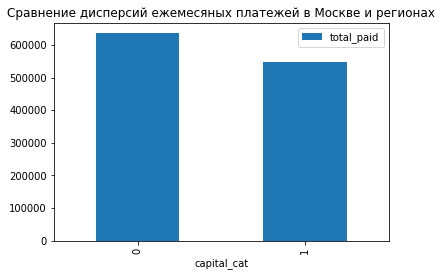

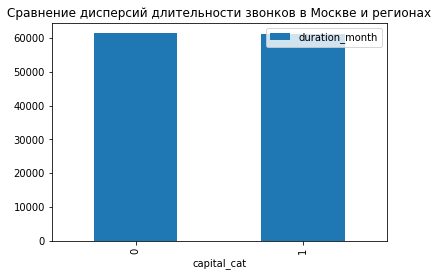

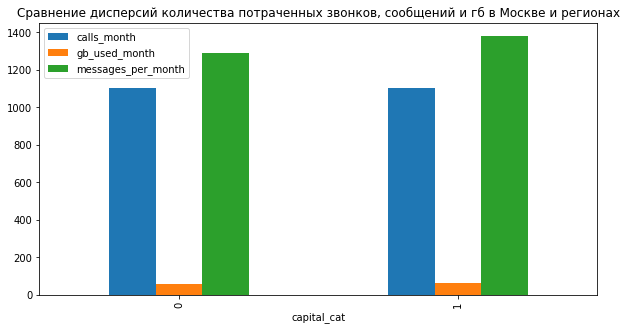

In [ ]:
data.pivot_table(index='capital_cat', values='total_paid', aggfunc='var').plot(kind='bar', title='Сравнение дисперсий ежемесяных платежей в Москве и регионах')
data.pivot_table(index='capital_cat', values='duration_month', aggfunc='var').plot(kind='bar', title='Сравнение дисперсий длительности звонков в Москве и регионах')
data.pivot_table(index='capital_cat', values=['calls_month', 'messages_per_month', 'gb_used_month'], aggfunc='var').plot(kind='bar', title='Сравнение дисперсий количества потраченных звонков, сообщений и гб в Москве и регионах', figsize=(10,5))


<div class="alert alert-info">
    
<b>Сравнение дисперсий ежемесяных платежей в Москве и регионах:</b> В регионах ненамного больше разнообразие ежемесячных платежей.
    
<b>Сравнение дисперсий длительности звонков в Москве и регионах:</b> По разнообразию количества потраченных минут в Москве и регионах разницы не видно.
    
<b>Сравнение дисперсий количества потраченных звонков, сообщений и гб в Москве и регионах:</b> Почти нет разницы между Москвой и регионами. В регионах чуть разнообразнее количество сообщений.

</div>

In [ ]:
data.groupby('tariff')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,46.556303,16.353371,18.0,32.0,47.0,62.0,75.0
ultra,985.0,46.834518,17.107979,18.0,30.0,45.0,63.0,75.0


По возрасту абонентов выборки практически не различаются.

### Сравнение настоящих и бывших абонентов

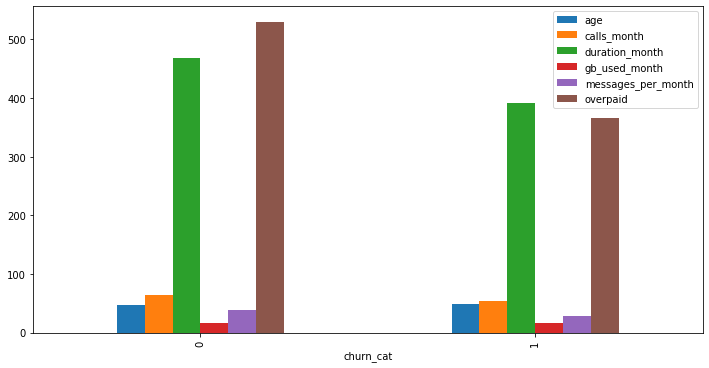

In [ ]:
data.pivot_table(index='churn_cat', values=['age', 'overpaid', 'duration_month', 'calls_month', 'messages_per_month',
       'gb_used_month']).plot(kind='bar', figsize=(12, 6))

Сравнивая выборки действующих и ушедших от оператора абонентов, можно сказать, что ушедшие заметно меньше переплачивали и пользовались телефонной связью.

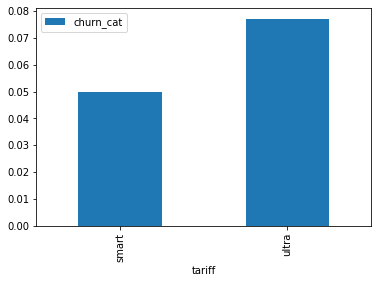

In [ ]:
data.pivot_table(index='tariff', values='churn_cat').plot(kind='bar')

Доля бывших абонентов выше у Ультра

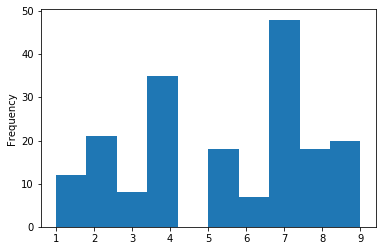

In [ ]:
(data.query('churn_cat == 1')['churn_month'] - data.query('churn_cat == 1')['reg_month']).plot(kind='hist')

<div class="alert alert-info">Самый большой пик - 7 месяцев с Мегалайном. Также выделяется 4 месяца. Посмотрим по тарифам.</div>

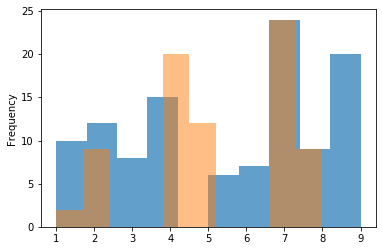

In [ ]:
churn_smart = data.query('churn_cat == 1 and tariff == "smart"')['churn_month'] - data.query('churn_cat == 1 and tariff == "smart"')['reg_month']
churn_ultra = data.query('churn_cat == 1 and tariff == "ultra"')['churn_month'] - data.query('churn_cat == 1 and tariff == "ultra"')['reg_month']
churn_smart.plot(kind='hist', alpha=0.7)
churn_ultra.plot(kind='hist', alpha=0.5)
plt.show()

<div class="alert alert-info">Пик в 7 месяцев общий для двух тарифов - большое количество абонентов ушло именно после 7 меяцев с оператором. Так же стоит отметить пик в 4 месяца для "Ультра" и пик в 9 месяцев для "Смарт"</div>

**7 месяцев**

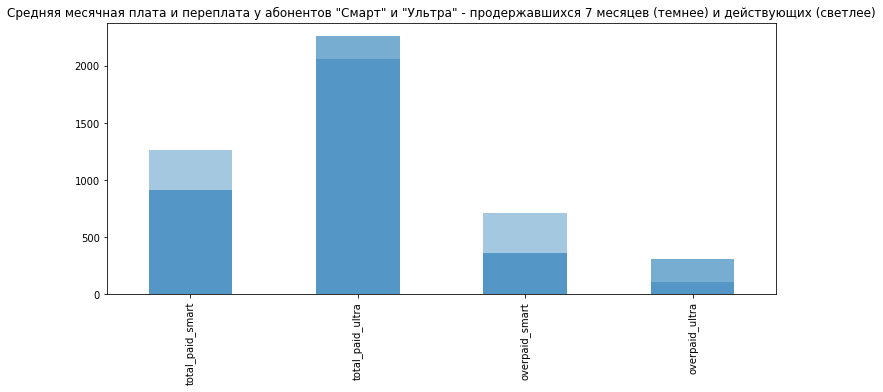

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'total_paid', 'overpaid']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'total_paid', 'overpaid']], on='user_id', how='outer').rename(columns={'total_paid_x':'total_paid_smart_7_month', 'total_paid_y':'total_paid_ultra_7_month', 'overpaid_x': 'overpaid_smart_7_month', 'overpaid_y': 'overpaid_ultra_7_month'})[['total_paid_smart_7_month', 'total_paid_ultra_7_month', 'overpaid_smart_7_month', 'overpaid_ultra_7_month']].mean().plot(kind='bar', alpha=0.6, title='Средняя месячная плата и переплата у абонентов "Смарт" и "Ультра" - продержавшихся 7 месяцев (темнее) и действующих (светлее)', figsize=(12,5))
data.query('churn_cat == 0 and tariff == "smart"')[['user_id', 'total_paid', 'overpaid']].merge(data.query('churn_cat == 0 and tariff == "ultra"')[['user_id', 'total_paid', 'overpaid']], on='user_id', how='outer').rename(columns={'total_paid_x':'total_paid_smart', 'total_paid_y':'total_paid_ultra', 'overpaid_x': 'overpaid_smart', 'overpaid_y': 'overpaid_ultra'})[['total_paid_smart', 'total_paid_ultra', 'overpaid_smart', 'overpaid_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
По сравнению с действующими абонентами ушедшие от оператора после 7 месяцев использования связи абоненты "Смарта" платили меньшие суммы.

А вот абоненты "Ультра", наоборот, переплачивали.
</div>

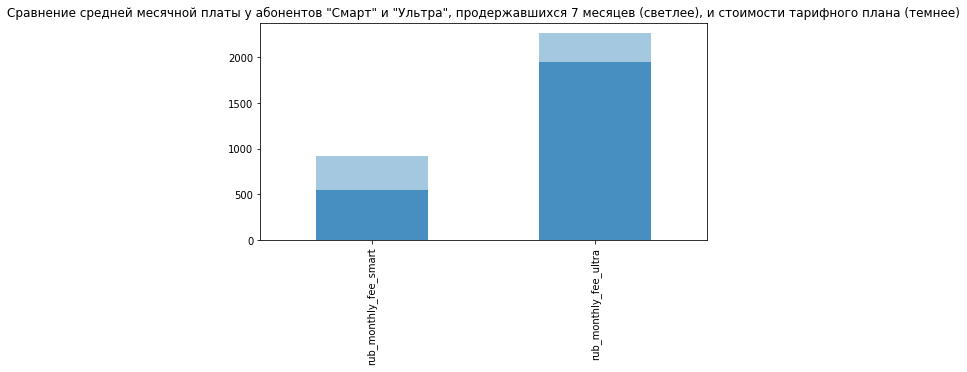

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'total_paid']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'total_paid']], on='user_id', how='outer').rename(columns={'total_paid_x':'total_paid_smart_7_month', 'total_paid_y':'total_paid_ultra_7_month'})[['total_paid_smart_7_month', 'total_paid_ultra_7_month']].mean().plot(kind='bar', alpha=0.4, title='Сравнение средней месячной платы у абонентов "Смарт" и "Ультра", продержавшихся 7 месяцев (светлее), и стоимости тарифного плана (темнее)', figsize=(8,4))
data.query('tariff == "smart"')[['user_id', 'rub_monthly_fee']].merge(data.query('tariff == "ultra"')[['user_id', 'rub_monthly_fee']], on='user_id', how='outer').rename(columns={'rub_monthly_fee_x':'rub_monthly_fee_smart', 'rub_monthly_fee_y':'rub_monthly_fee_ultra'})[['rub_monthly_fee_smart', 'rub_monthly_fee_ultra']].mean().plot(kind='bar', alpha=0.7)
plt.show()

<div class="alert alert-info">
Абоненты обоих тарифов, ушедшие после 7 месяцев, переплачивали сверх тарифа.
</div>

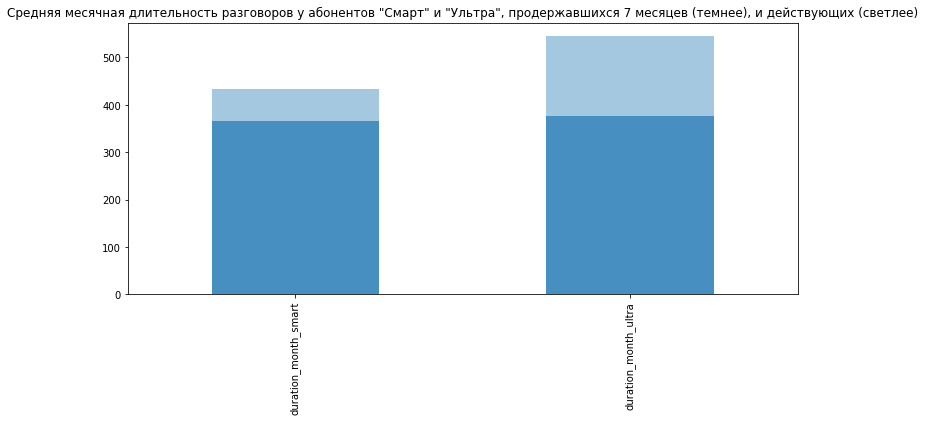

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'duration_month']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'duration_month']], on='user_id', how='outer').rename(columns={'duration_month_x':'duration_month_smart_7_month', 'duration_month_y':'duration_month_ultra_7_month'})[['duration_month_smart_7_month', 'duration_month_ultra_7_month']].mean().plot(kind='bar', alpha=0.7, title='Средняя месячная длительность разговоров у абонентов "Смарт" и "Ультра", продержавшихся 7 месяцев (темнее), и действующих (светлее)', figsize=(12,5))
data.query('churn_cat == 0 and tariff == "smart"')[['user_id', 'duration_month']].merge(data.query('churn_cat == 0 and tariff == "ultra"')[['user_id', 'duration_month']], on='user_id', how='outer').rename(columns={'duration_month_x':'duration_month_smart', 'duration_month_y':'duration_month_ultra'})[['duration_month_smart', 'duration_month_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Бывшие абоненты обоих тарифов пользовались телефонной связью меньше действующих. В случае абонентов "Ультра" - существенно меньше. То есть пакет звонков был им велик.
</div>

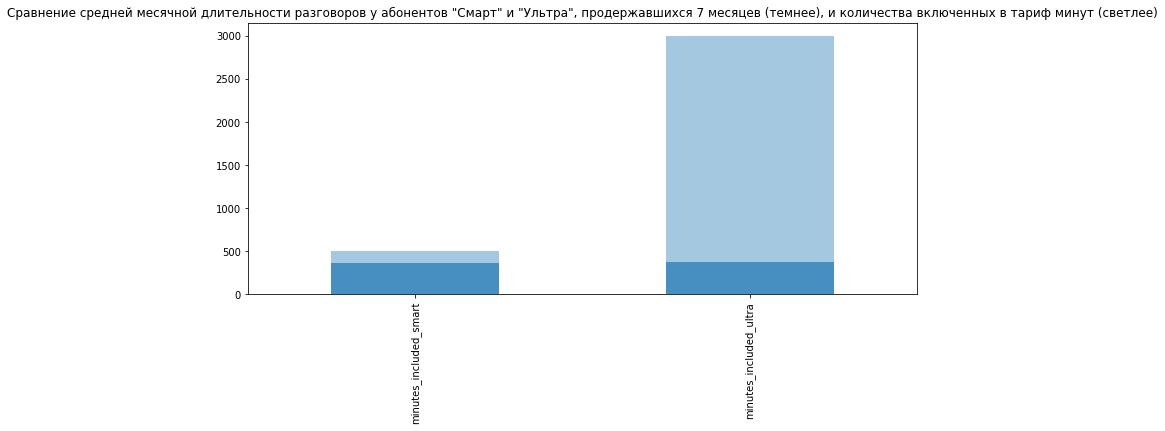

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'duration_month']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'duration_month']], on='user_id', how='outer').rename(columns={'duration_month_x':'duration_month_smart_7_month', 'duration_month_y':'duration_month_ultra_7_month'})[['duration_month_smart_7_month', 'duration_month_ultra_7_month']].mean().plot(kind='bar', alpha=0.7, title='Сравнение средней месячной длительности разговоров у абонентов "Смарт" и "Ультра", продержавшихся 7 месяцев (темнее), и количества включенных в тариф минут (светлее)', figsize=(12,5))
data.query('tariff == "smart"')[['user_id', 'minutes_included' ]].merge(data.query('tariff == "ultra"')[['user_id', 'minutes_included']], on='user_id', how='outer').rename(columns={'minutes_included_x':'minutes_included_smart', 'minutes_included_y':'minutes_included_ultra'})[['minutes_included_smart', 'minutes_included_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Если абоненты "Смарт" в целом почти использовали свой пакет звонков, то абоненты "Ультра" его почти не использовали - бОльшая часть минут сгорала.
</div>

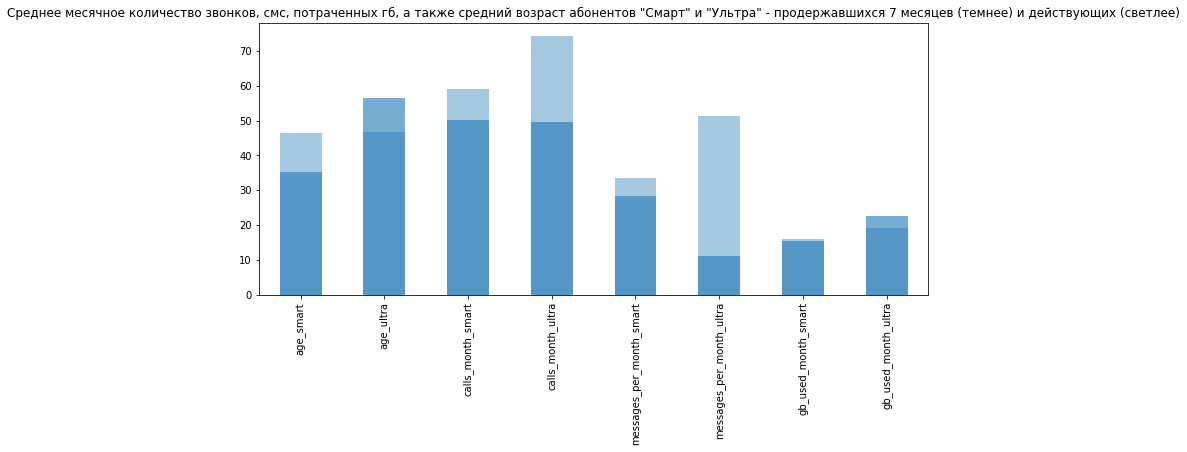

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'age', 'calls_month', 'messages_per_month',
       'gb_used_month']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'age', 'calls_month', 'messages_per_month',
       'gb_used_month']], on='user_id', how='outer').rename(columns={'age_x':'age_smart_7_month', 'age_y':'age_ultra_7_month', 'calls_month_x':'calls_month_smart_7_month', 'calls_month_y':'calls_month_ultra_7_month', 'messages_per_month_x':'messages_per_month_smart_7_month', 'messages_per_month_y':'messages_per_month_ultra_7_month', 'gb_used_month_x':'gb_used_month_smart_7_month', 'gb_used_month_y':'gb_used_month_ultra_7_month'})[['age_smart_7_month', 'age_ultra_7_month', 'calls_month_smart_7_month', 'calls_month_ultra_7_month', 'messages_per_month_smart_7_month', 'messages_per_month_ultra_7_month', 'gb_used_month_smart_7_month', 'gb_used_month_ultra_7_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество звонков, смс, потраченных гб, а также средний возраст абонентов "Смарт" и "Ультра" - продержавшихся 7 месяцев (темнее) и действующих (светлее)', figsize=(12,5))
data.query('churn_cat == 0 and tariff == "smart"')[['user_id', 'age', 'calls_month', 'messages_per_month',
       'gb_used_month']].merge(data.query('churn_cat == 0 and tariff == "ultra"')[['user_id', 'age', 'calls_month', 'messages_per_month',
       'gb_used_month']], on='user_id', how='outer').rename(columns={'age_x':'age_smart', 'age_y':'age_ultra', 'calls_month_x':'calls_month_smart', 'calls_month_y':'calls_month_ultra', 'messages_per_month_x':'messages_per_month_smart', 'messages_per_month_y':'messages_per_month_ultra', 'gb_used_month_x':'gb_used_month_smart', 'gb_used_month_y':'gb_used_month_ultra'})[['age_smart', 'age_ultra', 'calls_month_smart', 'calls_month_ultra', 'messages_per_month_smart', 'messages_per_month_ultra', 'gb_used_month_smart', 'gb_used_month_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Средний возраст бывших абонентов "Смарт" меньше среднего возраста действующих абонентов "Смарт".
У "Ультра" наоборот - средний возраст бывших абонентов "Ультра" больше среднего возраста действующих абонентов "Ультра". И существенно больше среднего возраста бывших абонентов "Смарт".
    
Как мы уже видели на диаграмме длительности, бывшие абоненты "Ультра" совершали гораздо меньшее количество звонков, чем настоящие. Бывшие абоненты "Смарт" тоже реже звонили.
    
Сообщений бывшие абоненты тоже отправляли меньше, причем бывшие "Ультра" отправляли сообщений почти в 4 раза меньше, чем действующие.
    
Бывшие 7-месячные абоненты "Ультра" расходовали больше гб, чем настоящие.
Расход гб у бывших "Смарт" совсем немного превышает этот показатель у настоящих. Им нужен просто более экономный пакет. 
</div>

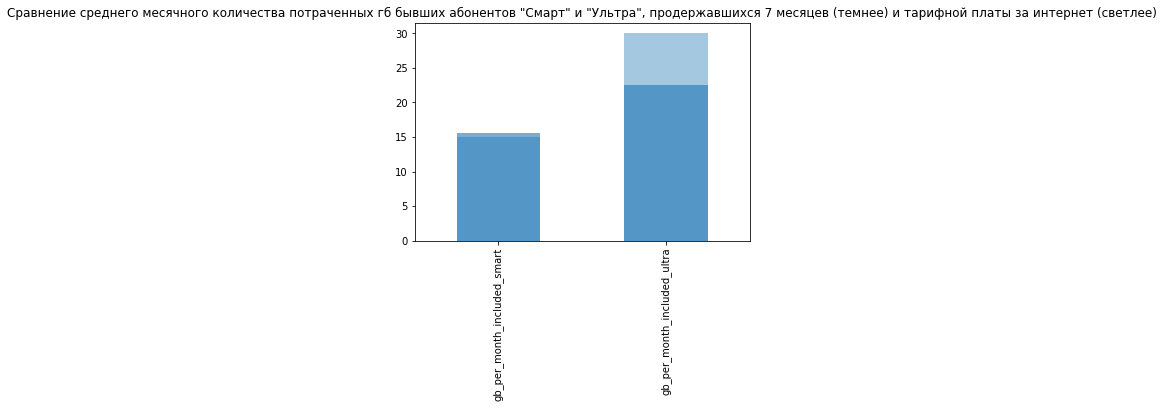

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'gb_used_month']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'gb_used_month']], on='user_id', how='outer').rename(columns={'gb_used_month_x':'gb_used_month_smart_7_month', 'gb_used_month_y':'gb_used_month_ultra_7_month'})[['gb_used_month_smart_7_month', 'gb_used_month_ultra_7_month']].mean().plot(kind='bar', alpha=0.6, title='Сравнение среднего месячного количества потраченных гб бывших абонентов "Смарт" и "Ультра", продержавшихся 7 месяцев (темнее) и тарифной платы за интернет (светлее)')
data.query('tariff == "smart"')[['user_id', 'gb_per_month_included']].merge(data.query('tariff == "ultra"')[['user_id', 'gb_per_month_included']], on='user_id', how='outer').rename(columns={'gb_per_month_included_x':'gb_per_month_included_smart', 'gb_per_month_included_y':'gb_per_month_included_ultra'})[['gb_per_month_included_smart', 'gb_per_month_included_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Но пакета гб ушедшим после 7-ми месяцев абонентам "Ультра" всё равно было много. "Смарт", ушедшие после 7 месяцев, в среднем немного вылезали за пакет гб.
</div>

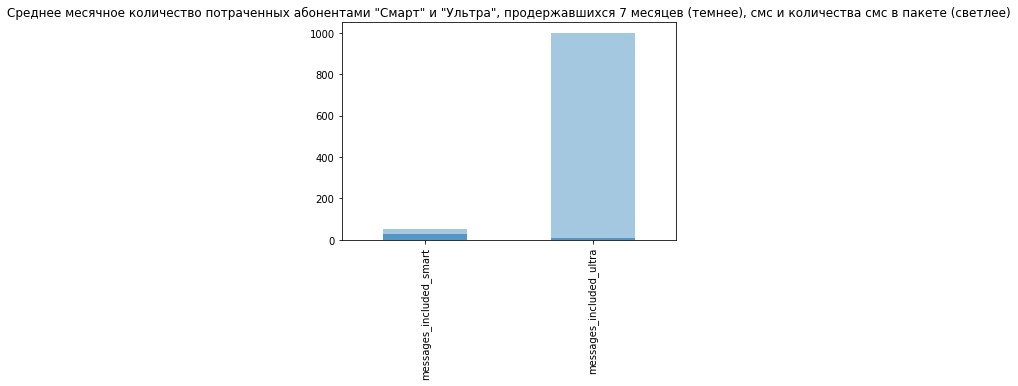

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "smart"')[['user_id', 'messages_per_month']].merge(data.query('churn_cat == 1 and churn_month == reg_month + 7 and tariff == "ultra"')[['user_id', 'messages_per_month']], on='user_id', how='outer').rename(columns={'messages_per_month_x':'messages_per_month_smart_7_month', 'messages_per_month_y':'messages_per_month_ultra_7_month'})[['messages_per_month_smart_7_month', 'messages_per_month_ultra_7_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество потраченных абонентами "Смарт" и "Ультра", продержавшихся 7 месяцев (темнее), смс и количества смс в пакете (светлее)')
data.query('churn_cat == 0 and tariff == "smart"')[['user_id', 'messages_included']].merge(data.query('churn_cat == 0 and tariff == "ultra"')[['user_id', 'messages_included']], on='user_id', how='outer').rename(columns={'messages_included_x':'messages_included_smart', 'messages_included_y':'messages_included_ultra'})[['messages_included_smart', 'messages_included_ultra']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Пакета сообщений абонентам обоих тарифов было много, но "Смарт" все же использовали существенную часть, у 7-месячных "Ультра" он в среднем почти целиком сгорал.
</div>

**4 месяца "Ультра"**

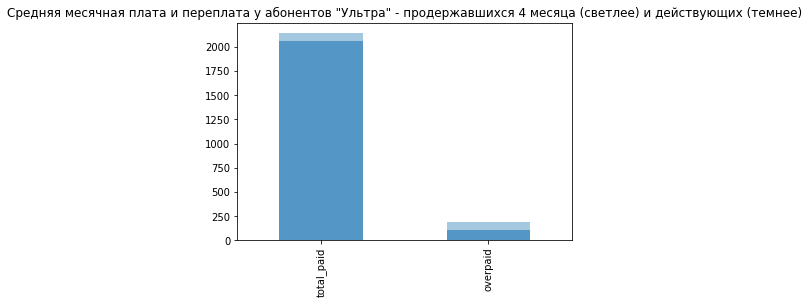

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['total_paid', 'overpaid']].mean().plot(kind='bar', alpha=0.4, title='Средняя месячная плата и переплата у абонентов "Ультра" - продержавшихся 4 месяца (светлее) и действующих (темнее)')
data.query('churn_cat == 0 and tariff == "ultra"')[['total_paid', 'overpaid']].mean().plot(kind='bar', alpha=0.6)
plt.show()

<div class="alert alert-info">
Абоненты "Ультра", продержавшиеся только 4 месяца, платили больше действующих абонентов смарт (полагаю, что опять за интернет - увидим ниже).
</div>

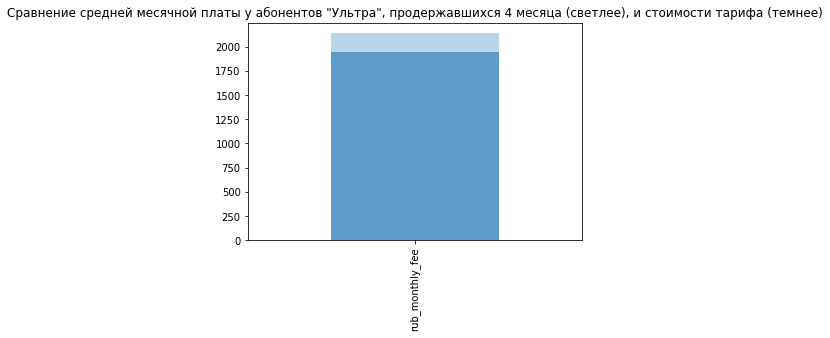

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['total_paid']].mean().plot(kind='bar', alpha=0.3, title='Сравнение средней месячной платы у абонентов "Ультра", продержавшихся 4 месяца (светлее), и стоимости тарифа (темнее)')
data.query('tariff == "ultra"')[['rub_monthly_fee']].mean().plot(kind='bar', alpha=0.6)
plt.show()

<div class="alert alert-info">
Ушедшие после 4 месяцев абоненты "Ультра" переплачивали за свой тариф.
</div>

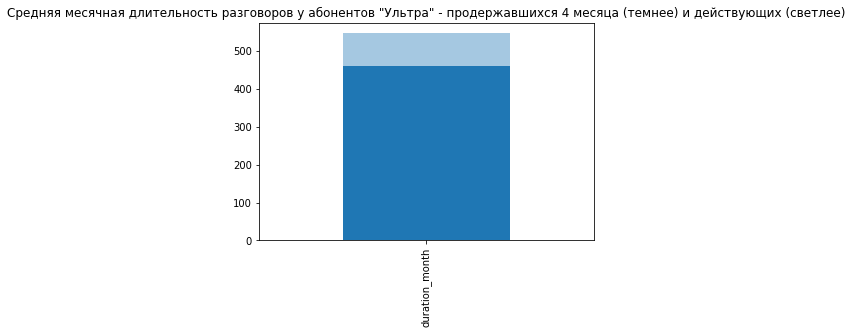

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['duration_month']].mean().plot(kind='bar', title='Средняя месячная длительность разговоров у абонентов "Ультра" - продержавшихся 4 месяца (темнее) и действующих (светлее)')
data.query('churn_cat == 0 and tariff == "ultra"')[['duration_month']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Раговаривали ушедшие с "Ультра" после 4 месяцев связи меньше действующих абонентов "Ультра".
</div>

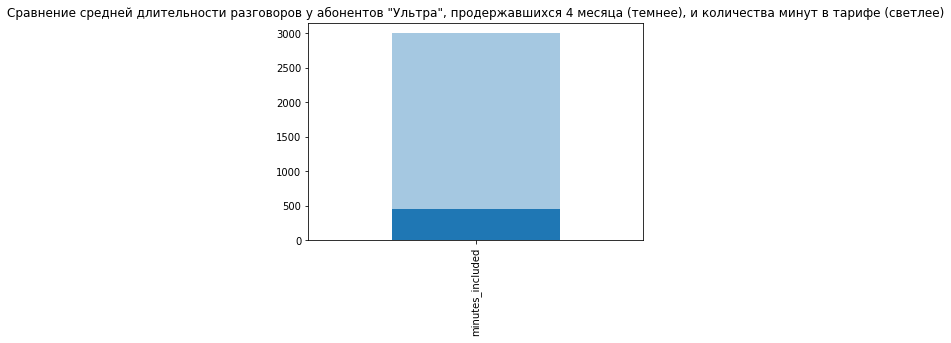

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['duration_month']].mean().plot(kind='bar', title='Сравнение средней длительности разговоров у абонентов "Ультра", продержавшихся 4 месяца (темнее), и количества минут в тарифе (светлее)')
data.query('tariff == "ultra"')[['minutes_included']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Пакет звонков у абонентов "Ультра", ушедших после 4 месяцев, оставался едва тронутым.
</div>

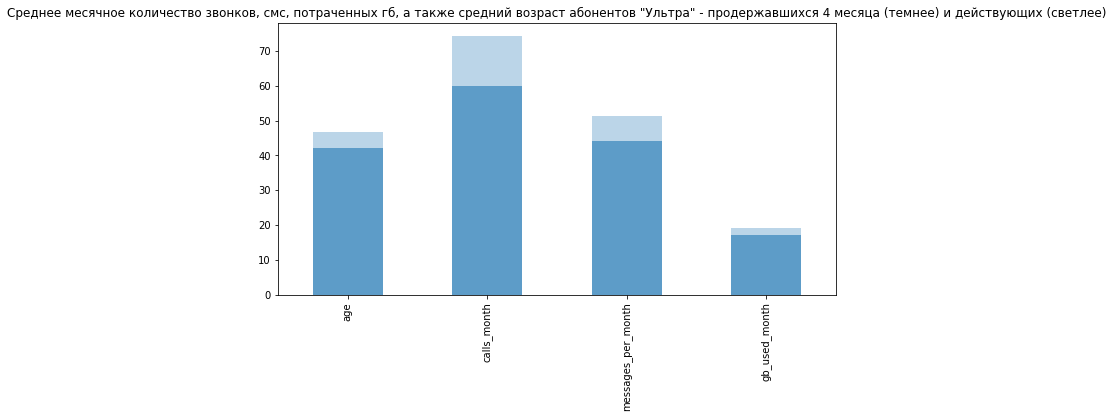

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['age', 'calls_month', 'messages_per_month',
       'gb_used_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество звонков, смс, потраченных гб, а также средний возраст абонентов "Ультра" - продержавшихся 4 месяца (темнее) и действующих (светлее)', figsize=(10,5))
data.query('churn_cat == 0 and tariff == "ultra"')[['age', 'calls_month', 'messages_per_month',
       'gb_used_month']].mean().plot(kind='bar', alpha=0.3)

<div class="alert alert-info">
С возрастом, количеством звонков и смс картина похожа на ушедших после 7 месяцев, но с меньшим разрывом. А вот с гб нет - бывшие абоненты "Ультра" тратили их меньше действующих.
</div>

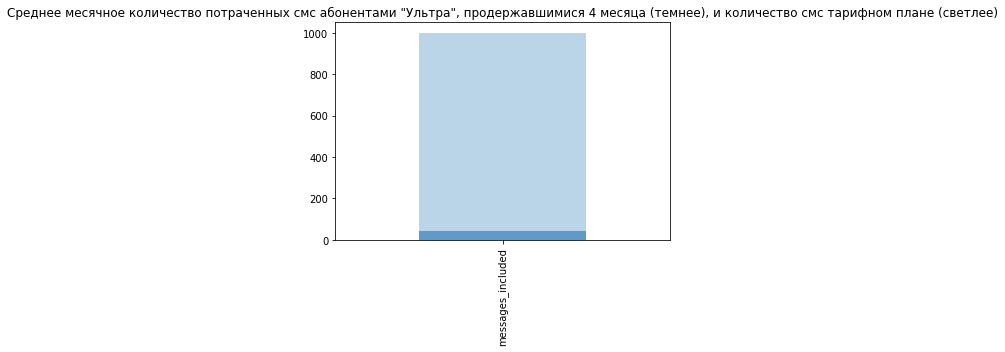

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['messages_per_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество потраченных смс абонентами "Ультра", продержавшимися 4 месяца (темнее), и количество смс тарифном плане (светлее)')
data.query('tariff == "ultra"')[['messages_included']].mean().plot(kind='bar', alpha=0.3)

<div class="alert alert-info">
Пакет смс у абонентов "Ультра", ушедших после 4 месяцев, оставался в среднем почти не тронутым.
</div>

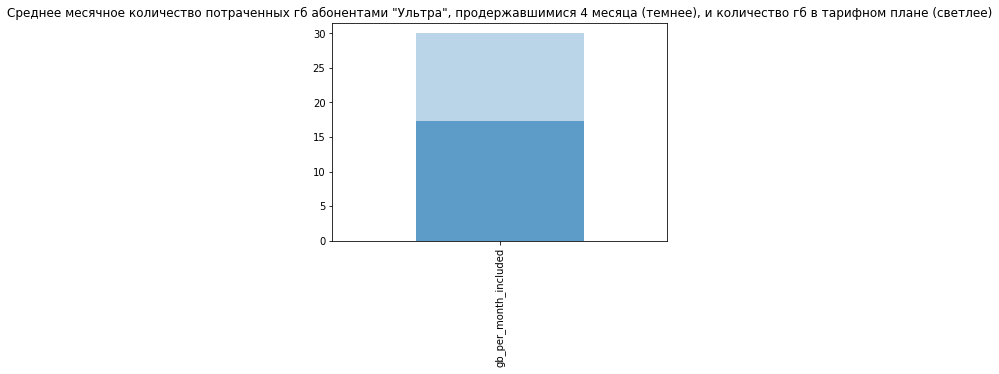

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 4 and tariff == "ultra"')[['gb_used_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество потраченных гб абонентами "Ультра", продержавшимися 4 месяца (темнее), и количество гб в тарифном плане (светлее)')
data.query('tariff == "ultra"')[['gb_per_month_included']].mean().plot(kind='bar', alpha=0.3)

<div class="alert alert-info">
Пакет гб хоть и расходовался активнее, всё равно был чрезмерно большим.
</div>

**9 месяцев "Смарт"**

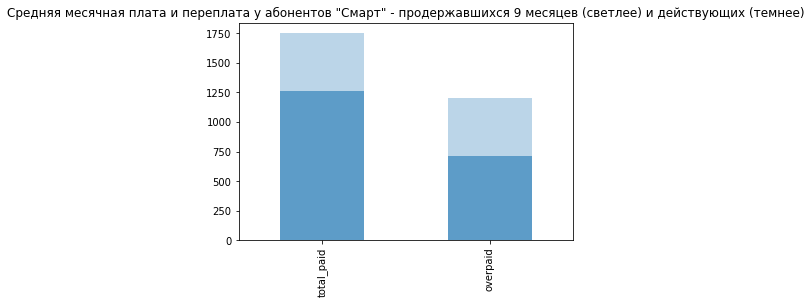

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['total_paid', 'overpaid']].mean().plot(kind='bar', alpha=0.3, title='Средняя месячная плата и переплата у абонентов "Смарт" - продержавшихся 9 месяцев (светлее) и действующих (темнее)')
data.query('churn_cat == 0 and tariff == "smart"')[['total_paid', 'overpaid']].mean().plot(kind='bar', alpha=0.6)
plt.show()

<div class="alert alert-info">
Ушедшие после 9 месяцев абоненты "Смарт" платили существенно больше действующих.
</div>

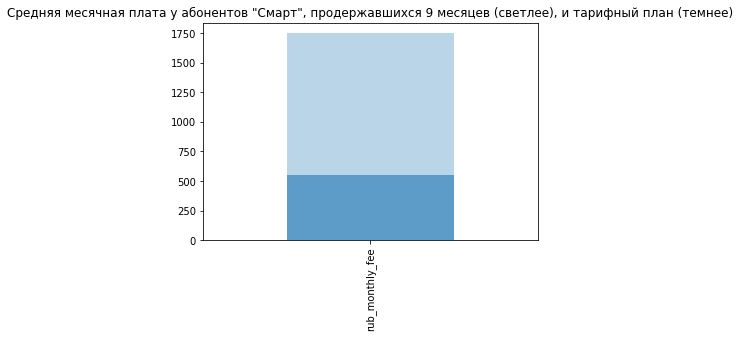

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['total_paid', 'overpaid']].mean().plot(kind='bar', alpha=0.3, title='Средняя месячная плата у абонентов "Смарт", продержавшихся 9 месяцев (светлее), и тарифный план (темнее)')
data.query('tariff == "smart"')[['rub_monthly_fee']].mean().plot(kind='bar', alpha=0.6)
plt.show()

<div class="alert alert-info">
Они платили почти в три раза больше стоимости тарифа.
</div>

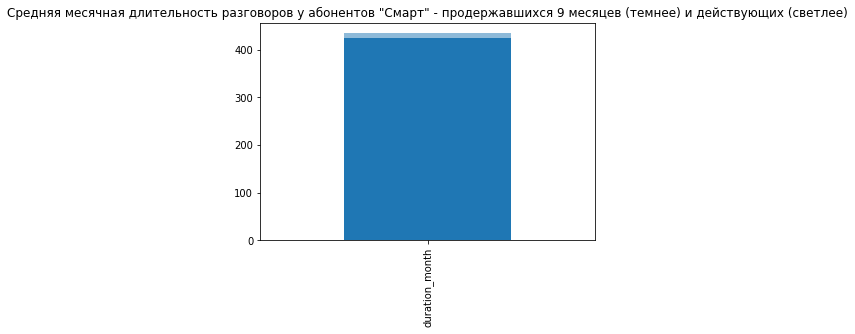

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['duration_month']].mean().plot(kind='bar', title='Средняя месячная длительность разговоров у абонентов "Смарт" - продержавшихся 9 месяцев (темнее) и действующих (светлее)')
data.query('churn_cat == 0 and tariff == "smart"')[['duration_month']].mean().plot(kind='bar', alpha=0.5)
plt.show()

<div class="alert alert-info">
Бывшие и настоящие абоненты "Смарт" разговаривали примерно одинаковое время.
</div>

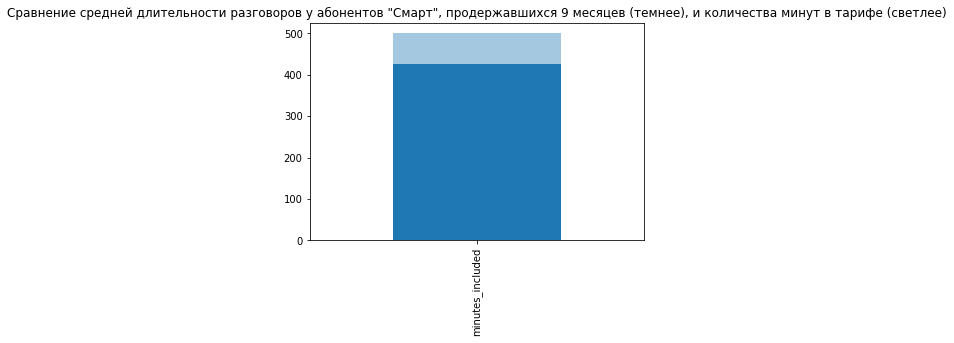

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['duration_month']].mean().plot(kind='bar', title='Сравнение средней длительности разговоров у абонентов "Смарт", продержавшихся 9 месяцев (темнее), и количества минут в тарифе (светлее)')
data.query('tariff == "smart"')[['minutes_included']].mean().plot(kind='bar', alpha=0.4)
plt.show()

<div class="alert alert-info">
Пакет минут оставался не до конца израсходован.
</div>

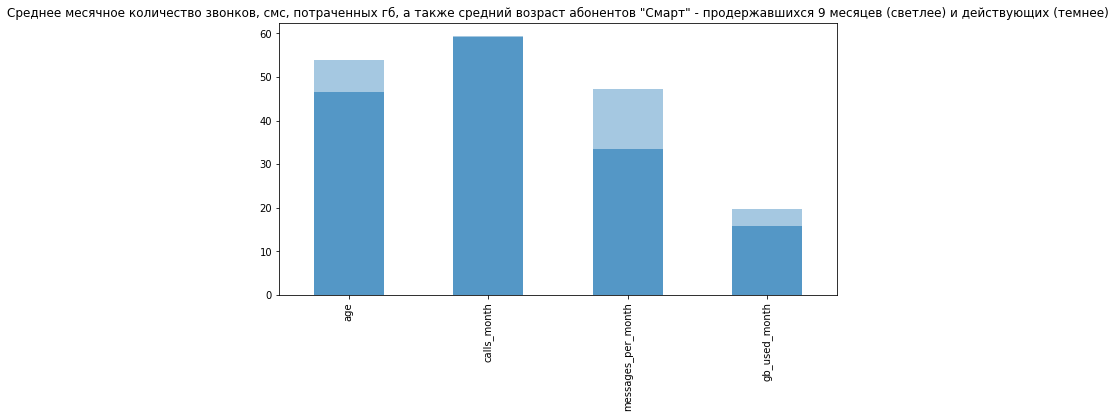

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['age', 'calls_month', 'messages_per_month',
       'gb_used_month']].mean().plot(kind='bar', alpha=0.4, title='Среднее месячное количество звонков, смс, потраченных гб, а также средний возраст абонентов "Смарт" - продержавшихся 9 месяцев (светлее) и действующих (темнее)', figsize=(10,5))
data.query('churn_cat == 0 and tariff == "smart"')[['age', 'calls_month', 'messages_per_month',
       'gb_used_month']].mean().plot(kind='bar', alpha=0.6)
plt.show()

<div class="alert alert-info">
Бывшие (ушедшие через 9 месяцев) абоненты "Смарт" были в среднем старше, отправляли больше сообщений и расходовали больше гб, чем настоящие.
</div>

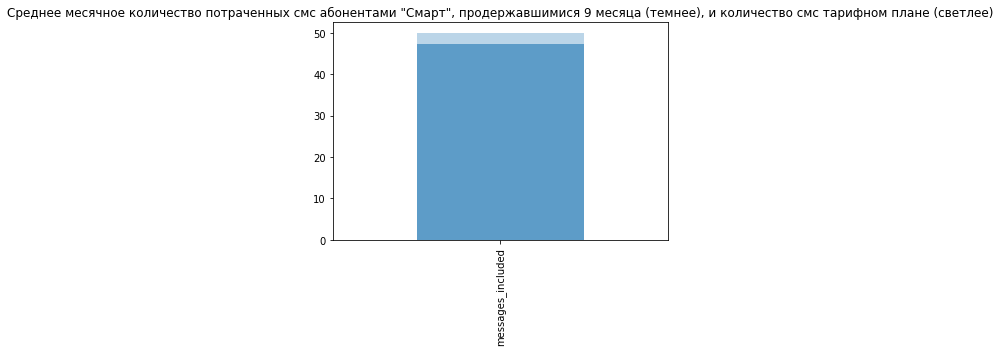

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['messages_per_month']].mean().plot(kind='bar', alpha=0.6, title='Среднее месячное количество потраченных смс абонентами "Смарт", продержавшимися 9 месяца (темнее), и количество смс тарифном плане (светлее)')
data.query('tariff == "smart"')[['messages_included']].mean().plot(kind='bar', alpha=0.3)

<div class="alert alert-info">
Пакет смс расходовался почти полностью.
</div>

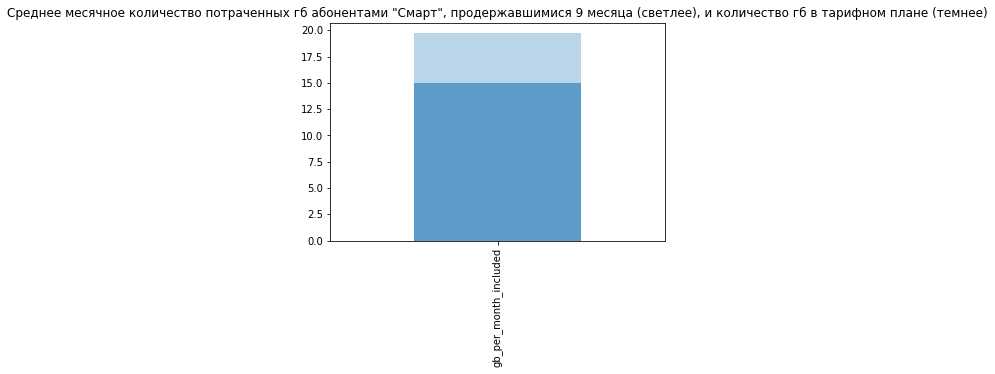

In [ ]:
data.query('churn_cat == 1 and churn_month == reg_month + 9 and tariff == "smart"')[['gb_used_month']].mean().plot(kind='bar', alpha=0.3, title='Среднее месячное количество потраченных гб абонентами "Смарт", продержавшимися 9 месяца (светлее), и количество гб в тарифном плане (темнее)')
data.query('tariff == "smart"')[['gb_per_month_included']].mean().plot(kind='bar', alpha=0.6)

<div class="alert alert-info">
А по гб случался перерасход, приводивший к переплатам.
</div>

In [ ]:
data.pivot_table(index=['churn_cat', 'tariff'], aggfunc={'duration_month': ['mean', 'std', 'var'], 'minutes_included': 'mean',  'user_id': 'count'}).reset_index()

churn_cat tariff duration_month                            minutes_included  \
                             mean         std            var             mean   
0         0  smart     434.397073  195.792469   38334.691101              500   
1         0  ultra     546.245325  328.695094  108040.465080             3000   
2         1  smart     335.072072  148.100808   21933.849304              500   
3         1  ultra     475.407895  281.788440   79404.724737             3000   

  user_id  
    count  
0    2118  
1     909  
2     111  
3      76

Но в целом по нашей выборке большинство ушло со тарифа "Смарт". Эти люди в большинстве своем не вылезали за пределы пакета звонков. Бывшим абонентам (и "Смарт", и "Ультра") было достаточно, и даже много пакета звонков. Возможно, если бы у оператора был еще один более гибкий тариф, они бы стали его абонентами. 

### Вывод
<div class="alert alert-info">
Мы видим два тарифа . "Ультра" - с большим пакетом услуг, дорогой (такой all inclusive тариф). А "Смарт" с гораздо меньшей фиксированной платой, но и с маленьким пакетом. "Смарт" в нашей выборке однозначно полулярнее, чем "Ультра". 
Абоненты "Ультра" активнее пользуются услугами оператора, редко вылезают за пределы своего тарифа.
Абоненты "Смарт" часто расходуют и оплачивают услуги сверх изначального пакета.
Общий доход выше от "Смарт", но у "Ультра" выше средний платёж.
Что касается доходов от столичных и нестоличных абонентов - в сумме Москва дает больше денег, но в среднем между Москвой и регионами, кажется, нет разницы. То же по расходу пакета услуг - столичные и нестоличные абоненты принципиально не различаются.
Бывшие абоненты заметно меньше переплачивали и пользовались телефонной связью. Доля бывших абонентов выше у тарифа "Ультра", но в целом по нашей выборке большинство ушло со "Смарт". Их всех объединяет то, что им, похоже было много имеющего пакета услуг (особенно ярко это видно по абонентам "Ультра", которым от пакета нужен в основном интернет, но и гигабайты они редко перерасходовали), и, возможно, они нашли более гибкий вариант у другого оператора. Если бы наш оператор предложил еще два тарифа с промежуточными условиями (с фиксированной платой меньше, чем у Смарт, и между Смарт и Ультра), они бы выбрали один из них.
</div>

## Статистический анализ данных

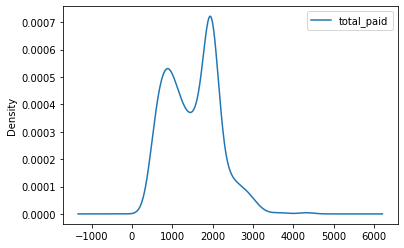

In [ ]:
data.pivot_table(index='user_id', values='total_paid').plot(kind='density')

График плотности распределения средних месячных платежей абонентов обоих тарифов. Площади под пиками на графике вероятно и есть наши два тарифа. Посмотрим на них по-отдельности. 

### Различие средней выручка пользователей тарифов «Ультра» и «Смарт» 

Посмотрим на то, сколько в среднем в месяц каждый пользователь платит за свой тариф "Ультра". Для начала избавимся от выбросов, рассматривая интервал усредненные по каждому пользователю данных, поместившихся внутри диаграммы размаха. 

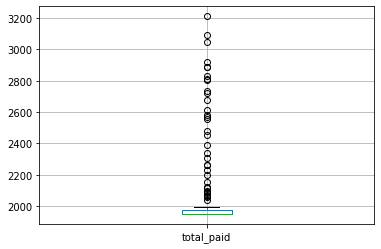

In [ ]:
data.query('tariff == "ultra"').pivot_table(index='user_id', values='total_paid').boxplot('total_paid')

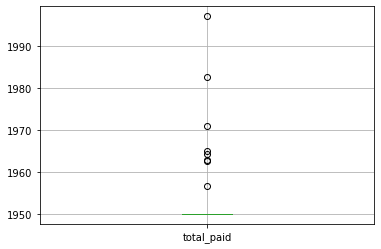

In [ ]:
data_ultra = data.query('tariff == "ultra"').pivot_table(index='user_id', values='total_paid')
data_ultra_r_border = data_ultra['total_paid'].quantile(0.75) + (data_ultra['total_paid'].quantile(0.75) - data_ultra['total_paid'].quantile(0.25))*1.5
data_ultra_l_border = data_ultra['total_paid'].quantile(0.25) - (data_ultra['total_paid'].quantile(0.75) - data_ultra['total_paid'].quantile(0.25))*1.5
data_ultra_n = data_ultra[(data_ultra['total_paid'] > data_ultra_l_border) & (data_ultra['total_paid'] < data_ultra_r_border)]
data_ultra_n.boxplot('total_paid')

In [ ]:
data_ultra_n['total_paid'].describe()

count     113.000000
mean     1951.433727
std         6.179069
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      1997.039795
Name: total_paid, dtype: float64

Помним, что подавляющее большинство платит фиксированную абонентскую плату, поэтому межквартильный размах (25-й и 75-й перцентили теперь стали равны) и дисперсия (примерно 36) здесь маленькие. 

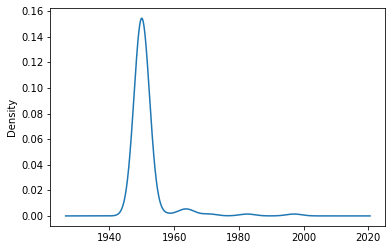

In [ ]:
data_ultra_n['total_paid'].plot(kind='density')

На графике плотности вероятности распределения дохода от тарифа Ультра видно, что самая большая площадь (вероятность) под пиком в 1950 рублей. Остальные ненулевые вероятности соответсвуют тем самым редким переплатам сверх тарифа. 

Теперь проделаем то же с тарифом "Смарт". Избавимся от выбросов. 

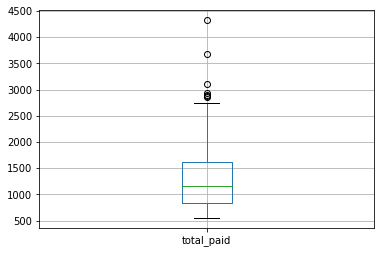

In [ ]:
data.query('tariff == "smart"').pivot_table(index='user_id', values='total_paid').boxplot('total_paid')

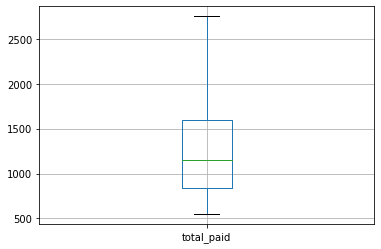

In [ ]:
data_smart = data.query('tariff == "smart"').pivot_table(index='user_id', values='total_paid')
data_smart_r_border = data_smart['total_paid'].quantile(0.75) + (data_smart['total_paid'].quantile(0.75) - data_smart['total_paid'].quantile(0.25))*1.5
data_smart_l_border = data_smart['total_paid'].quantile(0.25) - (data_smart['total_paid'].quantile(0.75) - data_smart['total_paid'].quantile(0.25))*1.5
data_smart_n = data_smart[(data_smart['total_paid'] > data_smart_l_border) & (data_smart['total_paid'] < data_smart_r_border)]
data_smart_n.boxplot('total_paid')

Дисперсия и межквартильный размах у "Смарт" куда выше, так как разнообразнее размер платежей - абоненты редко платят только фикс, часто вылезают за пределы тарифа. 

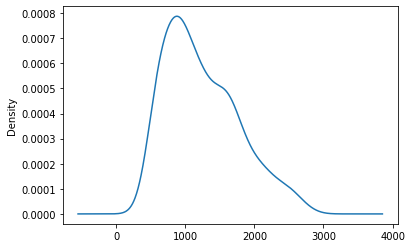

In [ ]:
data_smart_n['total_paid'].plot(kind='density')

На графике плотности распределения пик размером в абонентскую плату (550 рублей) не так выражен, как у Ультры, и так же велика площадь под графиком справа - те самые переплаты. 

Как-то так выглядят плотности распределений "Смарт" и "Ультра" вместе. 

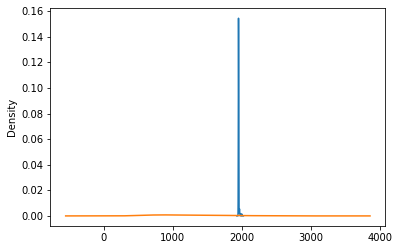

In [ ]:
data_ultra_n['total_paid'].plot(kind='density')
data_smart_n['total_paid'].plot(kind='density')
plt.show()

In [ ]:
print('Доход от тарифа Ультра:', data.query('tariff == "ultra"')['total_paid'].sum())
print('Доход от тарифа Смарт:', data.query('tariff == "smart"')['total_paid'].sum())

Доход от тарифа Ультра: 2029682.51953125
Доход от тарифа Смарт: 2789392.1484375


Вспомним, что доход от "Смарт" у оператора выше, чем от "Ультра" ("Смарт" чаще выбирают).

In [ ]:
data_n_describe = data_smart_n.describe()
data_n_describe['ultra_total_paid'] = data_ultra_n.describe()['total_paid']
data_n_describe.columns = ['smart_total_paid', 'ultra_total_paid']
data_n_describe

,smart_total_paid,ultra_total_paid
count,343.000000,113.000000
mean,1245.379937,1951.433727
std,527.165330,6.179069
min,550.000000,1950.000000
25%,834.535435,1950.000000
50%,1146.282118,1950.000000
75%,1602.443359,1950.000000
max,2752.009766,1997.039795


Несмотря на бОльшее количество денег в кассе "Смарт" среднее выше у "Ультра" (в нашей выборке абонентов "Ультра" меньше, чем абонентов "Смарт", отсюда меньшая сумма).

Исходя из таких данных предположим, что "Ультра" выгоднее для оператора, чем "Смарт".

Применим t-test для проверки этого предположения. 

Для того сформулируем гипотезы: 
* Н0: нет статистически значимого различия между выручками от тарифа "Ультра" и тарифа "Смарт".
* <div class="alert alert-info">Н1: выручки от тарифа "Ультра" и тарифа "Смарт" статистически значимо различаются.</div>

In [ ]:
alpha = 0.05

results = st.ttest_ind(
    data_ultra_n['total_paid'], 
    data_smart_n['total_paid'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем гипотезу H0")
else:
    print("Не получилось гипотезу H0")

p-значение: 3.0318333324050384e-38
Отвергаем гипотезу H0


<div class="alert alert-info">Между двумя выборками "Смарт" и "Ультра" существуют статистически значимые различия.</div>

### Различие средней выручки от пользователей из Москвы и из других регионов

А теперь проверим, разница ли выручка от абонентов из Москвы и абонентов не из Москвы. Визуально мы уже оценили этот параметр в предыдущем блоке (не различается). Теперь проверим статистически.

**Москва**

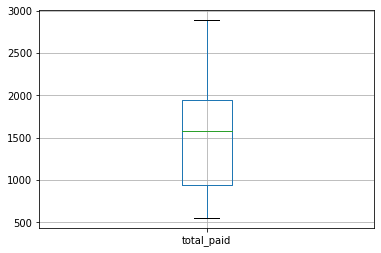

In [ ]:
data_capital_n = data.query('capital_cat == 1').pivot_table(index='user_id', values='total_paid')
data_capital_n.boxplot('total_paid')

Выбросов не видно.

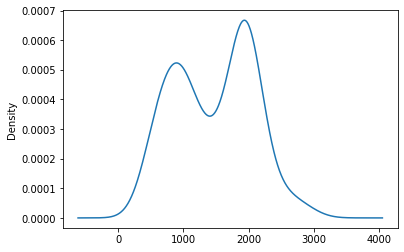

In [ ]:
data_capital_n['total_paid'].plot(kind='density')

Площади под пиками на графике, вероятно - два тарифа.

**Регионы**

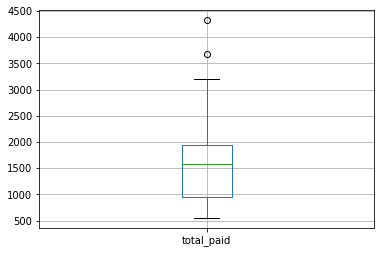

In [ ]:
data_not_capital = data.query('capital_cat == 0').pivot_table(index='user_id', values='total_paid')
data_not_capital.boxplot('total_paid')

Избавимся от выбросов

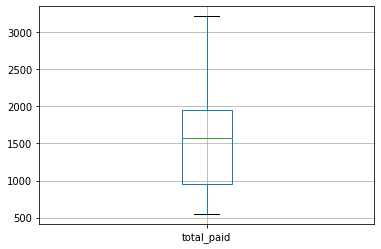

In [ ]:
data_not_capital_r_border = data_not_capital['total_paid'].quantile(0.75) + (data_not_capital['total_paid'].quantile(0.75) - data_not_capital['total_paid'].quantile(0.25))*1.5
data_not_capital_l_border = data_not_capital['total_paid'].quantile(0.25) - (data_not_capital['total_paid'].quantile(0.75) - data_not_capital['total_paid'].quantile(0.25))*1.5
data_not_capital_n = data_not_capital[(data_not_capital['total_paid'] > data_not_capital_l_border) & (data_not_capital['total_paid'] < data_not_capital_r_border)]
data_not_capital_n.boxplot('total_paid')

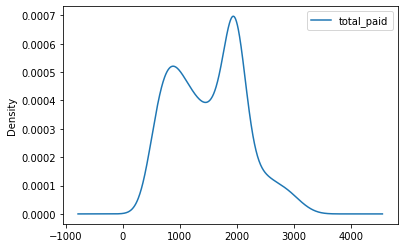

In [ ]:
data_not_capital_n.plot(kind='density')

График плотности распределения внешне сход с Московским.

In [ ]:
data_capital_describe = data_capital_n.describe()
data_capital_describe['not_capital_total_paid'] = data_not_capital_n.describe()['total_paid']
data_capital_describe.columns = ['capital_total_paid', 'ultra_total_paid']
data_capital_describe

,capital_total_paid,ultra_total_paid
count,99.000000,397.000000
mean,1471.218800,1520.066533
std,603.878959,620.240262
min,550.000000,550.000000
25%,935.165128,951.100911
50%,1584.275670,1575.009766
75%,1950.000000,1950.000000
max,2887.972656,3211.340332


Кажется, что разницы практически никакой нет. 

Сформулируем гипотезы:

* Н0: нет статистически значимого различия между выручками от абонентов из Москвы и абонентов из других городов.
* Н1: есть разница между выручками от абонентов из Москвы и абонентов из других городов.

In [ ]:
alpha = 0.05

results = st.ttest_ind(
    data_capital_n['total_paid'], 
    data_not_capital_n['total_paid'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем гипотезу H0")
else:
    print("Не получилось гипотезу H0")

p-значение: 0.4813224055305141
Не получилось гипотезу H0


С высокой вероятностью так и есть - нет разницы между доходом от абонентов из Москвы и абонентов из других городов. 

### Вывод
<div class="alert alert-info">
Тарифы "Ультра" и "Смарт" различаются по степени выгодности для оператора. Вероятно оператору имеет смысл чаще рекламировать условия тарифа "Ультра", чтобы увеличить его аудиторию. И, возможно, предложить похожий на "Ультра" тариф с несколько меньшим пакетом и абонентской платой.

Не удалось выявить различий в доходах от Москвы и регионов.
</div>

## Общий вывод

<div class="alert alert-info">
Тарифы "Ультра" и "Смарт" имеют значимое различие. Можно предположить, что "Ультра" в среднем выгоднее, и если вложиться в рекламу, то, возможно, станет приносить больше дохода. Однако всегда будут абоненты, которым не нужен такой большой пакет услуг. 

Главная рекомендация - пристальнее исследовать потребности абонентов. 
По данной выборке можно сказать, что определенно не хватает промежуточного между "Смарт" и "Ультра" тарифа, пакет которого будет включать большое количество гигабайт, а пакеты минут и смс будут минимальны, а так же тарифа более свободного, чем "Смарт" (с минимальной абонентской платой) - такие варианты помогли бы минимизировать отток абонентов.
</div>